<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis descriptivo de datos de contaminación del aire para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga del conjunto de datos</li>
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.3 Transformación de los datos
  <br>2.4 Análisis exploratorio de los datos
  <li>Selección de estaciones
</ol>
   
En primer lugar, cargamos todas las librerías que vamos a necesitar:

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import folium
import random
import seaborn;
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.pylab import rcParams
from statistics import mean
%matplotlib inline
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 10

# 1. Carga del conjunto de datos

El objetivo principal de este trabajo es el construir un modelo capaz de predecir la concentración de contaminantes en el aire en la ciudad de Barcelona. Para realizar este modelo, en primer lugar, debemos de contar con registros de datos de inmisión. La comunidad autónoma de Cataluña ofrece estos datos, en abierto, a través de su portal de [Open Data](https://analisi.transparenciacatalunya.cat/es). Concretamente en el enlace enlace: [aqui](https://analisi.transparenciacatalunya.cat/es/Medi-Ambient/Dades-d-immissi-dels-punts-de-mesurament-de-la-Xar/uy6k-2s8r), encontramos datos de inmisión de los puntos de medición de la Red de Vigilancia y Previsión de la Contaminación Atmosférica de Cataluña. Estos datos se ofrecen con distinta periodicidad horaria para distintos contaminantes del aire. Se tienen datos desde el año 1991 hasta el día anterior a la actual. En nuestro caso, nos interesan los datos registrados desde enero de 2010, en las estaciones de vigilancia ubicadas en la ciudad de Barcelona. Esta información se actualiza diariamente. Aparte de la concentración de los diferentes contaminantes también se podrá consultar: las coordenadas donde está ubicado el punto de medición, el tipo de estación, las unidades y la fecha de alta y de baja.

Estos datos se ofrecen con Licencia: [Open Data Commons Attribution License](https://opendatacommons.org/licenses/by/1.0/)

El siguiente código nos permite cargar los datos de inmisión, disponibles entre dos meses, en la ciudad de Barcelona (los datos predescargados están filtrados para Barcelona). Para ello, debemos modificar los valores asignados a las variables 'dataStartTime' y 'dataEndTime'.

In [2]:
dataStartTime = "2010-01"
dataEndTime = "2020-03"

# Header definition
columns=['CODI_MESURAMENT','CODI_EOI','PROVINCIA','CODI_MUNICIPI','CODI_ESTACIO','NOM_ESTACIO','MUNICIPI',
         'LATITUD','LONGITUD','ALTITUD','TIPUS_ESTACIO','AREA URBANA','MAGNITUD','CONTAMINANT','UNITATS',
         'PUNT_MOSTREIG','ANY','MES','DIA','DATA','H01','V01','H02','V02','H03','V03','H04','V04','H05','V05',
         'H06','V06','H07','V07','H08','V08','H09','V09','H10','V10','H11','V11','H12','V12','H13','V13',
         'H14','V14','H15','V15','H16','V16','H17','V17','H18','V18','H19','V19','H20','V20','H21','V21',
         'H22','V22','H23','V23','H24','V24','Georeferencia']
dtype={'CODI_MESURAMENT':object,
       'CODI_EOI':object,'PROVINCIA':object,'CODI_MUNICIPI':object,
       'CODI_ESTACIO':object,'NOM_ESTACIO':object,'MUNICIPI':object,
       'LATITUD':np.number,'LONGITUD':np.number,'ALTITUD':np.number,
       'TIPUS_ESTACIO':object,'AREA URBANA':object,'MAGNITUD':object,
       'CONTAMINANT':object,'UNITATS':object,'PUNT_MOSTREIG':object,
       'ANY':object,'MES':object,'DIA':object,'DATA':object,
       'H01':np.number,'V01':np.character,'H02':np.number,'V02':np.character,'H03':np.number,'V03':np.character,
       'H04':np.number,'V04':np.character,'H05':np.number,'V05':np.character,'H06':np.number,'V06':np.character,
       'H07':np.number,'V07':np.character,'H08':np.number,'V08':np.character,'H09':np.number,'V09':np.character,
       'H10':np.number,'V10':np.character,'H11':np.number,'V11':np.character,'H12':np.number,'V12':np.character,
       'H13':np.number,'V13':np.character,'H14':np.number,'V14':np.character,'H15':np.number,'V15':np.character,
       'H16':np.number,'V16':np.character,'H17':np.number,'V17':np.character,'H18':np.number,'V18':np.character,
       'H19':np.number,'V19':np.character,'H20':np.number,'V20':np.character,'H21':np.number,'V21':np.character,
       'H22':np.number,'V22':np.character,'H23':np.number,'V23':np.character,'H24':np.number,'V24':np.character,
       'Georeferencia':object}

# Read data to dataframe
data_air = pd.DataFrame(columns=columns)
for time in pd.date_range(dataStartTime+"-01T00:00:00.000", dataEndTime+"-01T00:00:00.000", freq='MS'):
    filename = time.strftime("../data/aire/aire_%Y_%m.zip")
    #print(filename)
    data_air = data_air.append(
        #pd.read_csv(filename, names=columns, sep=';', encoding = "ISO-8859-1", dtype=dtype)
        pd.read_csv(filename, names=columns, sep=';', encoding = "UTF-8", dtype=dtype)
        , ignore_index = True)

In [3]:
data_air.shape

(171597, 69)

Comprobamos que no se ha cargado ninguna instancia repetida. Si así fuera, tendríamos que eliminar aquellas que se repitan.

In [4]:
# Check whether duplicated rows and remove them, if so
duplicateRowsDF = data_air[data_air.duplicated()]
if len(duplicateRowsDF):
    data_air.drop_duplicates(inplace=True)  
    
print("Número de instancias duplicadas eliminadas: %d" % (len(duplicateRowsDF))) 

Número de instancias duplicadas eliminadas: 0


Mostramos las primeras instancias de nuestro dataframe para ver cómo son nuestros datos:

In [5]:
# Show first values in dataframe
data_air.head()

,CODI_MESURAMENT,CODI_EOI,PROVINCIA,CODI_MUNICIPI,CODI_ESTACIO,NOM_ESTACIO,MUNICIPI,LATITUD,LONGITUD,ALTITUD,TIPUS_ESTACIO,AREA URBANA,MAGNITUD,CONTAMINANT,UNITATS,PUNT_MOSTREIG,ANY,MES,DIA,DATA,H01,V01,H02,V02,H03,V03,H04,V04,H05,V05,H06,V06,H07,V07,H08,V08,H09,V09,H10,V10,H11,V11,H12,V12,H13,V13,H14,V14,H15,V15,H16,V16,H17,V17,H18,V18,H19,V19,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24,Georeferencia
0,8019056_10_20100101,8019056,8,19,56,Barcelona (Parc Vall Hebron),Barcelona,41.426109,2.148002,136.0,background,NaN,10,PM10,µg/m3,NaN,2010,1,1,2010-01-01T00:00:00.000,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,"(41.4261091, 2.148001585)"
1,8019044_14_20100101,8019044,8,19,44,Barcelona (Gracia - Sant Gervasi),Barcelona,41.398722,2.153399,57.0,traffic,NaN,14,O3,µg/m3,NaN,2010,1,1,2010-01-01T00:00:00.000,64.0,V,58.0,V,64.0,V,70.0,V,74.0,V,77.0,V,78.0,V,79.0,V,78.0,V,76.0,V,75.0,V,75.0,V,73.0,V,70.0,V,69.0,V,69.0,V,68.0,V,63.0,V,57.0,V,54.0,V,54.0,V,54.0,V,54.0,V,53.0,V,"(41.39872171, 2.153398848)"
2,8019004_8_20100101,8019004,8,19,4,Barcelona (Poblenou),Barcelona,41.403878,2.204501,3.0,background,NaN,8,NO2,µg/m3,NaN,2010,1,1,2010-01-01T00:00:00.000,12.0,V,17.0,V,13.0,V,6.0,V,5.0,V,6.0,V,8.0,V,5.0,V,5.0,V,5.0,V,5.0,V,6.0,V,9.0,V,13.0,V,12.0,V,8.0,V,10.0,V,12.0,V,16.0,V,20.0,V,20.0,V,14.0,V,13.0,V,11.0,V,"(41.40387833, 2.204500953)"
3,8019043_6_20100101,8019043,8,19,43,Barcelona (Eixample),Barcelona,41.385314,2.153800,26.0,traffic,NaN,6,CO,mg/m3,NaN,2010,1,1,2010-01-01T00:00:00.000,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,NaN,N,"(41.3853145, 2.153799918)"
4,8019042_6_20100101,8019042,8,19,42,Barcelona (Sants),Barcelona,41.378783,2.133099,35.0,traffic,NaN,6,CO,mg/m3,NaN,2010,1,1,2010-01-01T00:00:00.000,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,0.2,V,"(41.37878278, 2.133098953)"


Vemos como los datos están organizados en 69 columnas, que son:

- 'CODI_MESURAMENT', campo único formado por la concatenación de: EOI_Codi contaminant_AnyMesDia.
- 'CODI_EOI', código formado por: Província, Codi_Municipi y Codi_Estació.
- 'PROVINCIA', código numérico correspondiente a la provincia (08- Barcelona / 17 – Girona / 25 -Lleida / 43 -Tarragona).
- 'CODI_MUNICIPI', código numérico correspondiente al municipio.
- 'CODI_ESTACIO',cCódigo numérico correspondiente a la estación.
- 'NOM_ESTACIO', nombre de la estación de vigilancia. Valor alfanumérico de unos 100 caracteres. por ejemplo: Perafort (Puigdelfí).
- 'MUNICIPI', nombre del municipio donde se encuentra la estación. Valor alfanumérico de unos 100 caracteres. Por ejemplo: Perafort
- 'LATITUD' y 'LONGITUD', valores de latitud y longitud, respectivamente, expresadas en grados decimales en el sistema de referencia WGS84.
- 'ALTITUD, valor numérico de altitud de la estación dado en metros.
- 'TIPUS_ESTACIO', valores posibles: Fons (fondo), Industrial o Trànsit (tráfico).
- 'AREA URBANA', valores posibles: Rural, Suburbana o Urbana.
- 'MAGNITUD', código numérico que identifica el contaminante.
- 'CONTAMINANT', fórmula o mnemotécnico del contaminante.
- 'UNITATS', unidades de medida en la que está expresado el valor del contaminante.
- 'PUNT_MOSTREIG', identificador del punto de muestreo, incluye información de la estación de vigilancia y del contaminante.
- 'ANY', 'MES' y 'DIA', año, mes y día correspondiente al dato medida.
- 'DATA', fecha de la medida. Incluye los tres campos anteriores.
- 'Hxx' y'Vxx', pares de columnas que se repiten para cada hora del día, de 01 a 24, que contienen el valor medido del contaminante en la hora marcada y, un  flag de validacion que podrá tomar los valores: V, si el dato es válido; y N, en caso contrario.
- 'Georeferencia', columna de georeferencia (resulta redundante con los campos de latitud y longitud).

En nuestro caso, los datos descargados solamente incluyen valores registrados en las estaciones ubicadas en Barcelona.

In [6]:
data_air['CODI_EOI'].unique()

array(['8019056', '8019044', '8019004', '8019043', '8019042', '8019054',
       '8019057', '8019050', '8019003', '8019039', '8019058'],
      dtype=object)

# 2. Análisis de los datos

## 2.1 Análisis estadístico básico

Veamos como se distribuyen los datos de nuestro dataframe. 

En primer lugar vemos la distribución de las variables categóricas:

In [7]:
data_air.describe(include='O')

,CODI_MESURAMENT,CODI_EOI,PROVINCIA,CODI_MUNICIPI,CODI_ESTACIO,NOM_ESTACIO,MUNICIPI,TIPUS_ESTACIO,AREA URBANA,MAGNITUD,CONTAMINANT,UNITATS,PUNT_MOSTREIG,ANY,MES,DIA,DATA,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,Georeferencia
count,171597,171597,171597,171597,171509,171509,171597,171289,136614,171597,171597,171597,136922,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,171597,170276
unique,171597,11,1,1,11,13,1,3,3,9,9,3,75,11,12,31,3743,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,23
top,8019057_7_20150927,8019044,8,19,44,Barcelona (Parc Vall Hebron),Barcelona,background,urban,12,NOX,µg/m3,08019054_12_8,2019,1,5,2019-02-17T00:00:00.000,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,V,"(41.4261091, 2.148001585)"
freq,1,27434,171597,171597,27420,30340,171597,101464,132124,29108,29108,153174,3137,21428,16624,5680,132,136792,137451,139073,139274,139231,139227,139164,139032,138863,138111,135802,134333,134496,135550,135843,136565,138374,139233,139312,139394,139411,139151,139055,138380,23352


En primer lugar, se puede observar en la tabla, como el número de estaciones de vigilancia (campo CODI_ESTACIO) y el nombre de la estación (campo NOM_ESTACIO) no coinciden. Veremos más adelante cual es la razón de esta diferencia. Por otra parte, vemos, también, que el número de contaminates, para los cuales se han registrado datos, es de siete. Por otra parte, el número de coordenadas geográficas tampoco coincide con el número de estaciones. Lo cual, posiblemente se deba a una diferencia de precisión de estas.

A continuación, mostramos también los estadísticos básicos para los atríbutos cualitativos. En este caso, se han cargado como tales: latitud, longitud, altitud y cada una de las medidas registradas a cada hora. Los estadísticos mostrados aquí no tienen demasiada validez, pues están calculados para todos los contaminantes, sin distinción.

In [8]:
data_air.describe()

,LATITUD,LONGITUD,ALTITUD,H01,H02,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
count,171597.000000,171597.000000,171597.000000,136792.000000,137451.000000,139073.000000,139274.000000,139231.000000,139227.000000,139164.000000,139032.000000,138863.000000,138111.000000,135802.000000,134333.000000,134496.000000,135550.000000,135843.000000,136565.000000,138374.000000,139233.000000,139312.000000,139394.000000,139411.000000,139151.000000,139055.000000,138380.000000
mean,41.397762,2.151278,68.560284,29.698197,27.148187,24.860172,23.375152,22.178353,22.407792,26.379993,37.164600,45.923628,43.598226,37.653912,34.315998,32.300808,30.668395,28.799089,27.919452,28.730371,30.491642,32.628233,34.472932,35.542094,34.952014,33.345110,31.647602
std,0.015577,0.026901,73.103433,41.294487,37.643147,34.512150,31.997822,29.880911,29.293104,34.428796,52.355007,68.277181,64.840318,51.647649,42.832548,38.402247,35.262504,33.081518,32.576997,33.855968,36.398769,39.934238,43.355689,46.010092,46.642864,45.637414,44.038401
min,41.378780,2.115200,3.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.386403,2.133099,26.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,41.389726,2.153399,57.000000,17.000000,15.000000,13.000000,12.000000,12.000000,12.000000,16.000000,21.000000,25.000000,25.000000,23.000000,22.000000,21.000000,20.000000,18.000000,17.000000,17.000000,19.000000,20.000000,21.000000,22.000000,21.000000,20.000000,18.000000
75%,41.403878,2.153800,81.000000,44.000000,40.000000,37.000000,35.000000,33.000000,34.000000,40.000000,52.000000,60.000000,57.000000,52.000000,49.000000,47.000000,45.000000,43.000000,41.000000,43.000000,46.000000,50.000000,52.000000,53.000000,52.000000,50.000000,47.000000
max,41.426110,2.204501,415.000000,1138.000000,910.000000,1263.000000,879.000000,866.000000,748.000000,830.000000,1361.000000,1325.000000,1341.000000,1011.000000,915.000000,683.000000,664.000000,614.000000,632.000000,640.000000,766.000000,747.000000,956.000000,986.000000,1227.000000,1409.000000,1167.000000


Ahora vamos a visualizar la ubicación de las estaciones de vigilancia sobre un mapa de Barcelona. Pero lo primero que haremos será corregir algunas discrepancias en los datos. En primer lugar, corregimos la discrepancia entre los campos 'CODI_EOI' y 'NOM_ESTACIO (en nuestro caso, al tener unicamente las estaciones en el área de Barcelona, los campos 'CODI_ESTACIO' y 'CODI_EOI' son equivalentes). Para lo cual, vemos, primeramente, cuales son los valores únicos para cada una de estas dos columnas :

In [9]:
data_air['CODI_EOI'].unique()

array(['8019056', '8019044', '8019004', '8019043', '8019042', '8019054',
       '8019057', '8019050', '8019003', '8019039', '8019058'],
      dtype=object)

In [10]:
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Parc Vall Hebron)',
       'Barcelona (Gracia - Sant Gervasi)', 'Barcelona (Poblenou)',
       'Barcelona (Eixample)', 'Barcelona (Sants)',
       'Barcelona (Palau Reial)', 'Barcelona (Ciutadella)',
       'Barcelona (Torre Girona)', 'Barcelona (St. Gervasi)',
       'Barcelona (Sagrera)', 'Barcelona Observatori Fabra',
       'Barcelona (Observatori Fabra)',
       'Barcelona (Gràcia - Sant Gervasi)', nan], dtype=object)

Vemos como hay una discrepancia en el nombre dado a dos de las estaciones. Con el siguiente código corregimos este error en los datos:

In [11]:
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Gràcia - Sant Gervasi)'), ['NOM_ESTACIO']] = 'Barcelona (Gracia - Sant Gervasi)'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona Observatori Fabra'), ['NOM_ESTACIO']] = 'Barcelona (Observatori Fabra)'
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Parc Vall Hebron)',
       'Barcelona (Gracia - Sant Gervasi)', 'Barcelona (Poblenou)',
       'Barcelona (Eixample)', 'Barcelona (Sants)',
       'Barcelona (Palau Reial)', 'Barcelona (Ciutadella)',
       'Barcelona (Torre Girona)', 'Barcelona (St. Gervasi)',
       'Barcelona (Sagrera)', 'Barcelona (Observatori Fabra)', nan],
      dtype=object)

Vemos ahora cómo están catalogadas cada una de las estaciones según las variables 'TIPUS_ESTACIO' y 'AREA URBANA'.

In [12]:
data_air_type_stations=data_air.reset_index().groupby(['NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['CODI_EOI']\
        .agg(lambda x:x.value_counts().index[0])
data_air_type_stations

NOM_ESTACIO                        TIPUS_ESTACIO  AREA URBANA
Barcelona (Ciutadella)             background     urban          8019050
Barcelona (Eixample)               traffic        urban          8019043
Barcelona (Gracia - Sant Gervasi)  traffic        urban          8019044
Barcelona (Observatori Fabra)      0              0              8019058
                                   background     suburban       8019058
Barcelona (Palau Reial)            background     urban          8019057
Barcelona (Parc Vall Hebron)       background     urban          8019054
Barcelona (Poblenou)               background     urban          8019004
Barcelona (Sagrera)                traffic        urban          8019039
Barcelona (Sants)                  background     urban          8019042
                                   traffic        urban          8019042
Barcelona (St. Gervasi)            traffic        urban          8019003
Barcelona (Torre Girona)           background     urban       

Vemos que hay dos estaciones que tienen catalogaciones confusas según estos parámetros. Estas estaciones son las de:

- Observatori Fabra, que por una parte contiene instancias en las que no se ha especificado denominación y, otras en las que su denominación es de tipo estación 'background' y area 'suburban'. En este caso, optaremos por considerar esta segunda denominación.
- Sants, que, aunque siempre es considerada como una estación en area urbana, en algunos casos se considera como tipo de estación 'background' y en otros de tipo 'traffic'. Esto puede ser debido al cambio de denominación de la estación a lo largo del tiempo. Para simplicidad, en nuestro caso, vamos a considerar esta estación de tipo 'traffic'.

In [13]:
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Observatori Fabra)'), ['TIPUS_ESTACIO']] = 'background'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Observatori Fabra)'), ['AREA URBANA']] = 'suburban'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Sants)'), ['TIPUS_ESTACIO']] = 'traffic'

La otra discrepancia que vimos fué en las coordenadas geográficas dadas para cada estación. En este caso, lo que vamos a hacer para corregir esta diferencia, es obtener una tabla, con la información que necesitamos para su representación en el mapa, agregando por el valor más frecuente. De esta forma nos quedamos únicamente con una coordenada válida para cada estación.

In [14]:
# Aggregate by most frequent value
data_air_stations=data_air.reset_index().groupby(['CODI_EOI','NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['LATITUD','LONGITUD','ALTITUD']\
        .agg(lambda x:x.value_counts().index[0]).reset_index()
data_air_stations

,CODI_EOI,NOM_ESTACIO,TIPUS_ESTACIO,AREA URBANA,LATITUD,LONGITUD,ALTITUD
0,8019003,Barcelona (St. Gervasi),traffic,urban,41.401128,2.146942,75.0
1,8019004,Barcelona (Poblenou),background,urban,41.403878,2.204501,3.0
2,8019039,Barcelona (Sagrera),traffic,urban,41.422213,2.190555,12.0
3,8019042,Barcelona (Sants),traffic,urban,41.378783,2.133099,35.0
4,8019043,Barcelona (Eixample),traffic,urban,41.385314,2.153800,26.0
5,8019044,Barcelona (Gracia - Sant Gervasi),traffic,urban,41.398722,2.153399,57.0
6,8019050,Barcelona (Ciutadella),background,urban,41.386403,2.187398,7.0
7,8019054,Barcelona (Parc Vall Hebron),background,urban,41.426109,2.148002,136.0
8,8019056,Barcelona (Torre Girona),background,urban,41.389726,2.115836,81.0
9,8019057,Barcelona (Palau Reial),background,urban,41.387492,2.115200,81.0


Queremos ver ahora los contaminantes que son registrados en cada una de las estaciones.

In [15]:
data_air_contaminants_stations=data_air.reset_index().groupby(['CODI_EOI','NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['CONTAMINANT']\
    .unique().reset_index()
data_air_contaminants_stations

,CODI_EOI,NOM_ESTACIO,TIPUS_ESTACIO,AREA URBANA,CONTAMINANT
0,8019003,Barcelona (St. Gervasi),traffic,urban,"[H2S, NOX]"
1,8019004,Barcelona (Poblenou),background,urban,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
2,8019039,Barcelona (Sagrera),traffic,urban,[NOX]
3,8019042,Barcelona (Sants),traffic,urban,"[CO, NO, NO2, NOX, SO2]"
4,8019043,Barcelona (Eixample),traffic,urban,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
5,8019044,Barcelona (Gracia - Sant Gervasi),traffic,urban,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
6,8019050,Barcelona (Ciutadella),background,urban,"[CO, NO, NO2, NOX, O3]"
7,8019054,Barcelona (Parc Vall Hebron),background,urban,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
8,8019056,Barcelona (Torre Girona),background,urban,"[PM10, CO, H2S, NO, NO2, NOX, O3, SO2, PS]"
9,8019057,Barcelona (Palau Reial),background,urban,"[CO, NO, NO2, NOX, O3, PM10, SO2]"


Unimos ahora ambas tablas en una sola.

In [16]:
data_air_stations = pd.merge(data_air_stations, data_air_contaminants_stations, how='inner')
data_air_stations

,CODI_EOI,NOM_ESTACIO,TIPUS_ESTACIO,AREA URBANA,LATITUD,LONGITUD,ALTITUD,CONTAMINANT
0,8019003,Barcelona (St. Gervasi),traffic,urban,41.401128,2.146942,75.0,"[H2S, NOX]"
1,8019004,Barcelona (Poblenou),background,urban,41.403878,2.204501,3.0,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
2,8019039,Barcelona (Sagrera),traffic,urban,41.422213,2.190555,12.0,[NOX]
3,8019042,Barcelona (Sants),traffic,urban,41.378783,2.133099,35.0,"[CO, NO, NO2, NOX, SO2]"
4,8019043,Barcelona (Eixample),traffic,urban,41.385314,2.153800,26.0,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
5,8019044,Barcelona (Gracia - Sant Gervasi),traffic,urban,41.398722,2.153399,57.0,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
6,8019050,Barcelona (Ciutadella),background,urban,41.386403,2.187398,7.0,"[CO, NO, NO2, NOX, O3]"
7,8019054,Barcelona (Parc Vall Hebron),background,urban,41.426109,2.148002,136.0,"[CO, NO, NO2, NOX, O3, PM10, SO2]"
8,8019056,Barcelona (Torre Girona),background,urban,41.389726,2.115836,81.0,"[PM10, CO, H2S, NO, NO2, NOX, O3, SO2, PS]"
9,8019057,Barcelona (Palau Reial),background,urban,41.387492,2.115200,81.0,"[CO, NO, NO2, NOX, O3, PM10, SO2]"


Vemos que tenemos casi todas las estaciones son urbanas, excepto la estación de Observatori Fabra, que es suburbana. Además, cinco estaciones catalogadas como de tipo de estación 'traffic' y otras seis de tipo 'background'. Por otra parte, vemos que no todas las estaciones recogen todas las variables de contaminación.  

Guardamos estos datos por si nos pueden ser útiles en el futuro.

In [17]:
data_air_stations.to_csv(r'data_air_stations.csv', index = False)

Ahora tenemos ya los datos que necesitamos para visualizar las estaciones. Así, sobre el siguiente mapa de Barcelona podremos ver la ubicación de las estaciones de vigilancia.

In [18]:
lon=data_air_stations['LONGITUD'].tolist()
lat=data_air_stations['LATITUD'].tolist()

# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

for index, row in data_air_stations.iterrows():
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)
m

## 2.2 Transformación de los datos

A continuación, vamos a realizar algunas transformaciones en los datos para que nos sea más fácil trabajar con ellos.

En primer lugar, vamos a asignar el valor especial **NaN** a cada valor medido que tiene su correspondiente columna **Vxx** con el valor 'N'. Lo cual indica que ese dato no es válido.

In [19]:
# Set NaN value for observed data marked as not valid
for i in range(1,25):
    index='{:02d}'.format(i)
    data_air.loc[data_air['V'+index] == 'N', 'H'+index] = np.NaN

Lo siguiente que hacemos es cambiar la disposición de nuestros datos de tal forma que, tengamos una columna/atríbuto por cada contaminante, otra para la fecha y hora de la medida y, un atríbuto para el código de la estación de vigilancia.

In [20]:
data_air_hourly = pd.DataFrame()
codiEois = data_air['CODI_EOI'].unique()
for codiEoi in codiEois:
    data = data_air.loc[(data_air["CODI_EOI"] == codiEoi), ['DATA','CONTAMINANT','TIPUS_ESTACIO','AREA URBANA','H01','H02','H03','H04','H05','H06','H07','H08','H09','H10','H11','H12',
                          'H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24']]
    for hour in range(0,24):
        index='{:02d}'.format(hour+1) 
        dataGrouped = data.reset_index().groupby(['DATA','CONTAMINANT'])['H'+index].aggregate('first').unstack()    
        dataGrouped = dataGrouped.reset_index()
        dataGrouped['DATA'] = pd.DatetimeIndex(dataGrouped['DATA']) + pd.DateOffset(hours=hour)
        dataGrouped['CODI_EOI'] = codiEoi
        data_air_hourly = data_air_hourly.append(dataGrouped, ignore_index=True, sort=False)
data_air_hourly = data_air_hourly.sort_values(by='DATA')
data_air_hourly.shape

(736176, 11)

Vemos como las dimensiones de nuestro dataframe han cambiado respecto al dataframe original. Veamos ahora las primeras instancias de nuestro dataframe para hacernos una idea de su formato:

In [21]:
data_air_hourly.head()

,DATA,CO,H2S,NO,NO2,NOX,O3,PM10,PS,SO2,CODI_EOI
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8019056
70128,2010-01-01,0.2,NaN,3.0,13.0,NaN,64.0,NaN,NaN,NaN,8019044
159960,2010-01-01,0.2,NaN,3.0,12.0,17.0,44.0,NaN,NaN,1.0,8019004
609120,2010-01-01,1.2,NaN,3.0,27.0,30.0,55.0,NaN,NaN,4.0,8019050
339624,2010-01-01,0.2,NaN,2.0,17.0,19.0,NaN,NaN,NaN,2.0,8019042


Si hubiera algún valor **NaN** entre medias de las distintas series temporales, para cada contaminante, le asignamos el primer valor válido anterior. 

In [22]:
contaminants=data_air['CONTAMINANT'].unique()
for contaminant in contaminants:
    try:
        data_air_hourly[contaminant] = data_air_hourly[contaminant].fillna(data_air_hourly.groupby(['DATA', 'CODI_EOI'])[contaminant].ffill())
    except:
        pass

Ahora podemos obtener estadísticos básicos para cada uno de los contaminantes de forma independiente.

In [23]:
stats=data_air_hourly.describe()
stats

,CO,H2S,NO,NO2,NOX,O3,PM10,PS,SO2
count,351998.000000,0.0,610945.000000,610514.000000,579244.000000,446551.000000,226183.000000,0.0,359315.000000
mean,0.422773,NaN,17.037923,40.156949,65.153404,46.733148,24.800781,NaN,2.333994
std,0.312386,NaN,32.141796,26.357463,69.216459,28.940816,17.599951,NaN,2.368393
min,0.000000,NaN,-2.000000,0.000000,1.000000,0.000000,1.000000,NaN,1.000000
25%,0.200000,NaN,2.000000,19.000000,23.000000,23.000000,15.000000,NaN,1.000000
50%,0.300000,NaN,5.000000,34.000000,43.000000,47.000000,22.000000,NaN,2.000000
75%,0.500000,NaN,17.000000,56.000000,82.000000,67.000000,31.000000,NaN,3.000000
max,9.500000,NaN,810.000000,262.000000,1387.000000,236.000000,1409.000000,NaN,114.000000


Guardaremos estos datos en un fichero por si lo necesitaramos para estudios posteriores.

In [24]:
data_air_hourly.to_csv(r'data_air_hourly.csv', index = False)

## 2.3 Análisis exploratorio de los datos

Hasta ahora hemos visto como están organizados nuestros datos y analizado los estadísticos básicos de estos. Ahora vamos a explorar visualmente como es la distribución de nuestros datos y como varian en el tiempo.

En primer lugar, representamos gráficamente, en forma de boxplot, como se distribuyen los datos observados, en todas las estaciones, para cada una de las variables.

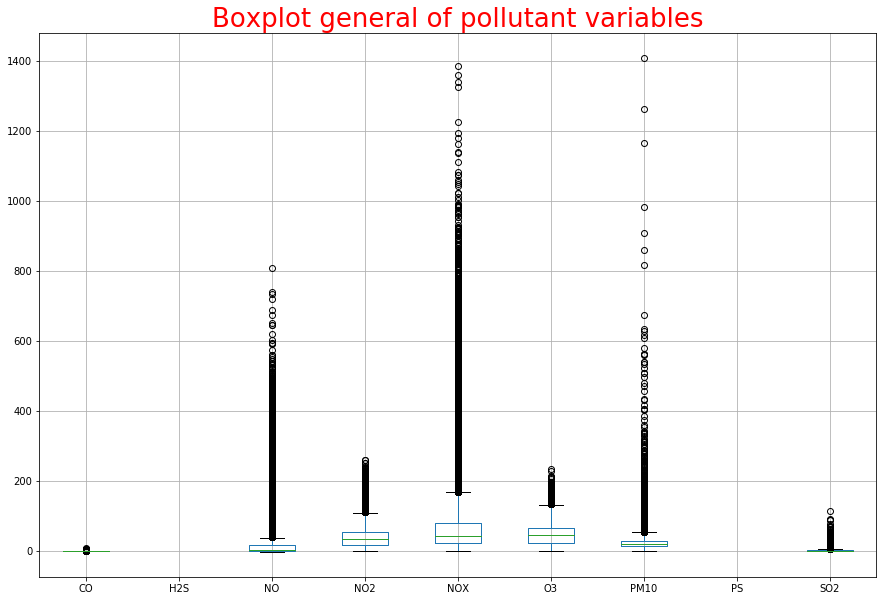

In [25]:
axes=data_air_hourly.boxplot(figsize=(15,10))
plt.title("Boxplot general of pollutant variables", fontsize=26, color='red')
plt.show()

La misma información la podemos representar agrupando los datos para cada variable por estaciones.

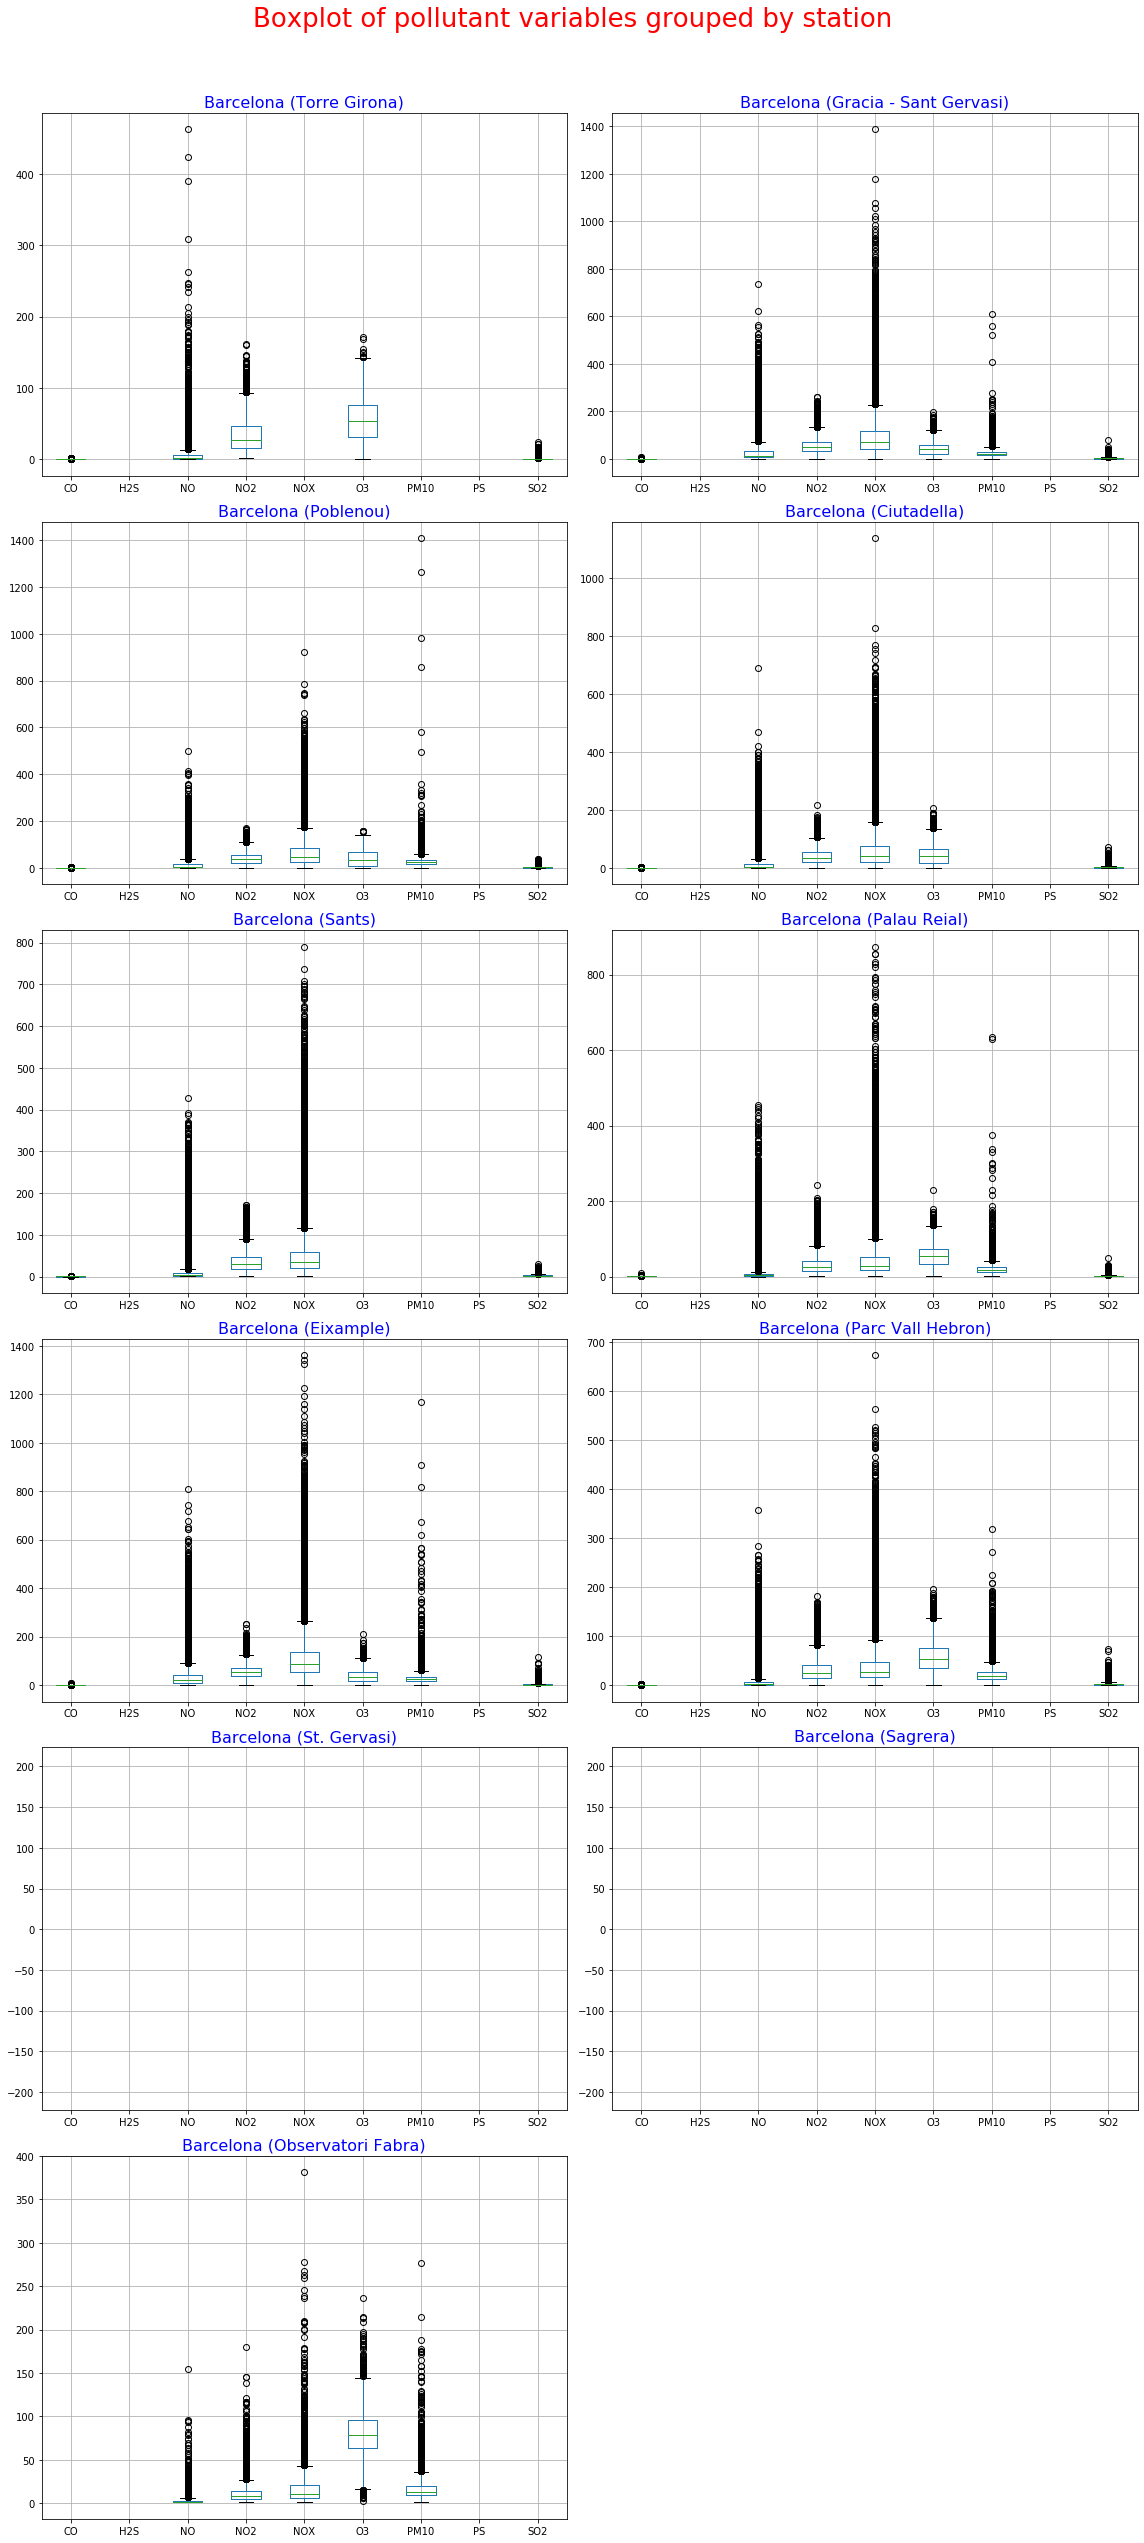

In [26]:
codiEois = data_air_hourly['CODI_EOI'].unique()
nroItems=len(codiEois)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

codiEois=np.append(codiEois, [None] * (nroItems % ncols))
        
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*8,nrows*6))
for codiEoi, ax in zip(codiEois, axes.flatten()):
    if codiEoi:
        nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == codiEoi,'NOM_ESTACIO'].iloc[0]
        title='{}'.format(nom_estacio)
        data_air_hourly[data_air_hourly["CODI_EOI"] == codiEoi].boxplot(ax=ax)
        ax.set_title(title, fontsize=16, color='blue')
    else:
        ax.remove()
plt.suptitle('Boxplot of pollutant variables grouped by station', fontsize=26, color='red')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Podemos observar, en estas figuras, la presencia de valores extremos. Sin embargo, en nuestro caso, optaremos por mantener estos datos, pues se entiende que son valores correctamente observados y posibles. También vemos en este gráfico, como no todos los contaminantes, de los que tenemos datos, son registrados en todas las estaciones. Así, por ejemplo, hay dos estaciones que no registran datos ni de CO, ni de O<sub>3</sub>, ni de SO<sub>2</sub>.

A continuación, evaluaremos la variabilidad de cada una de estas variables en el tiempo. Para ello, representamos los valores para cada una de los contaminantes, en cada una de las estaciones, con la variable de tiempo, 'DATA', en el eje de abscisas.

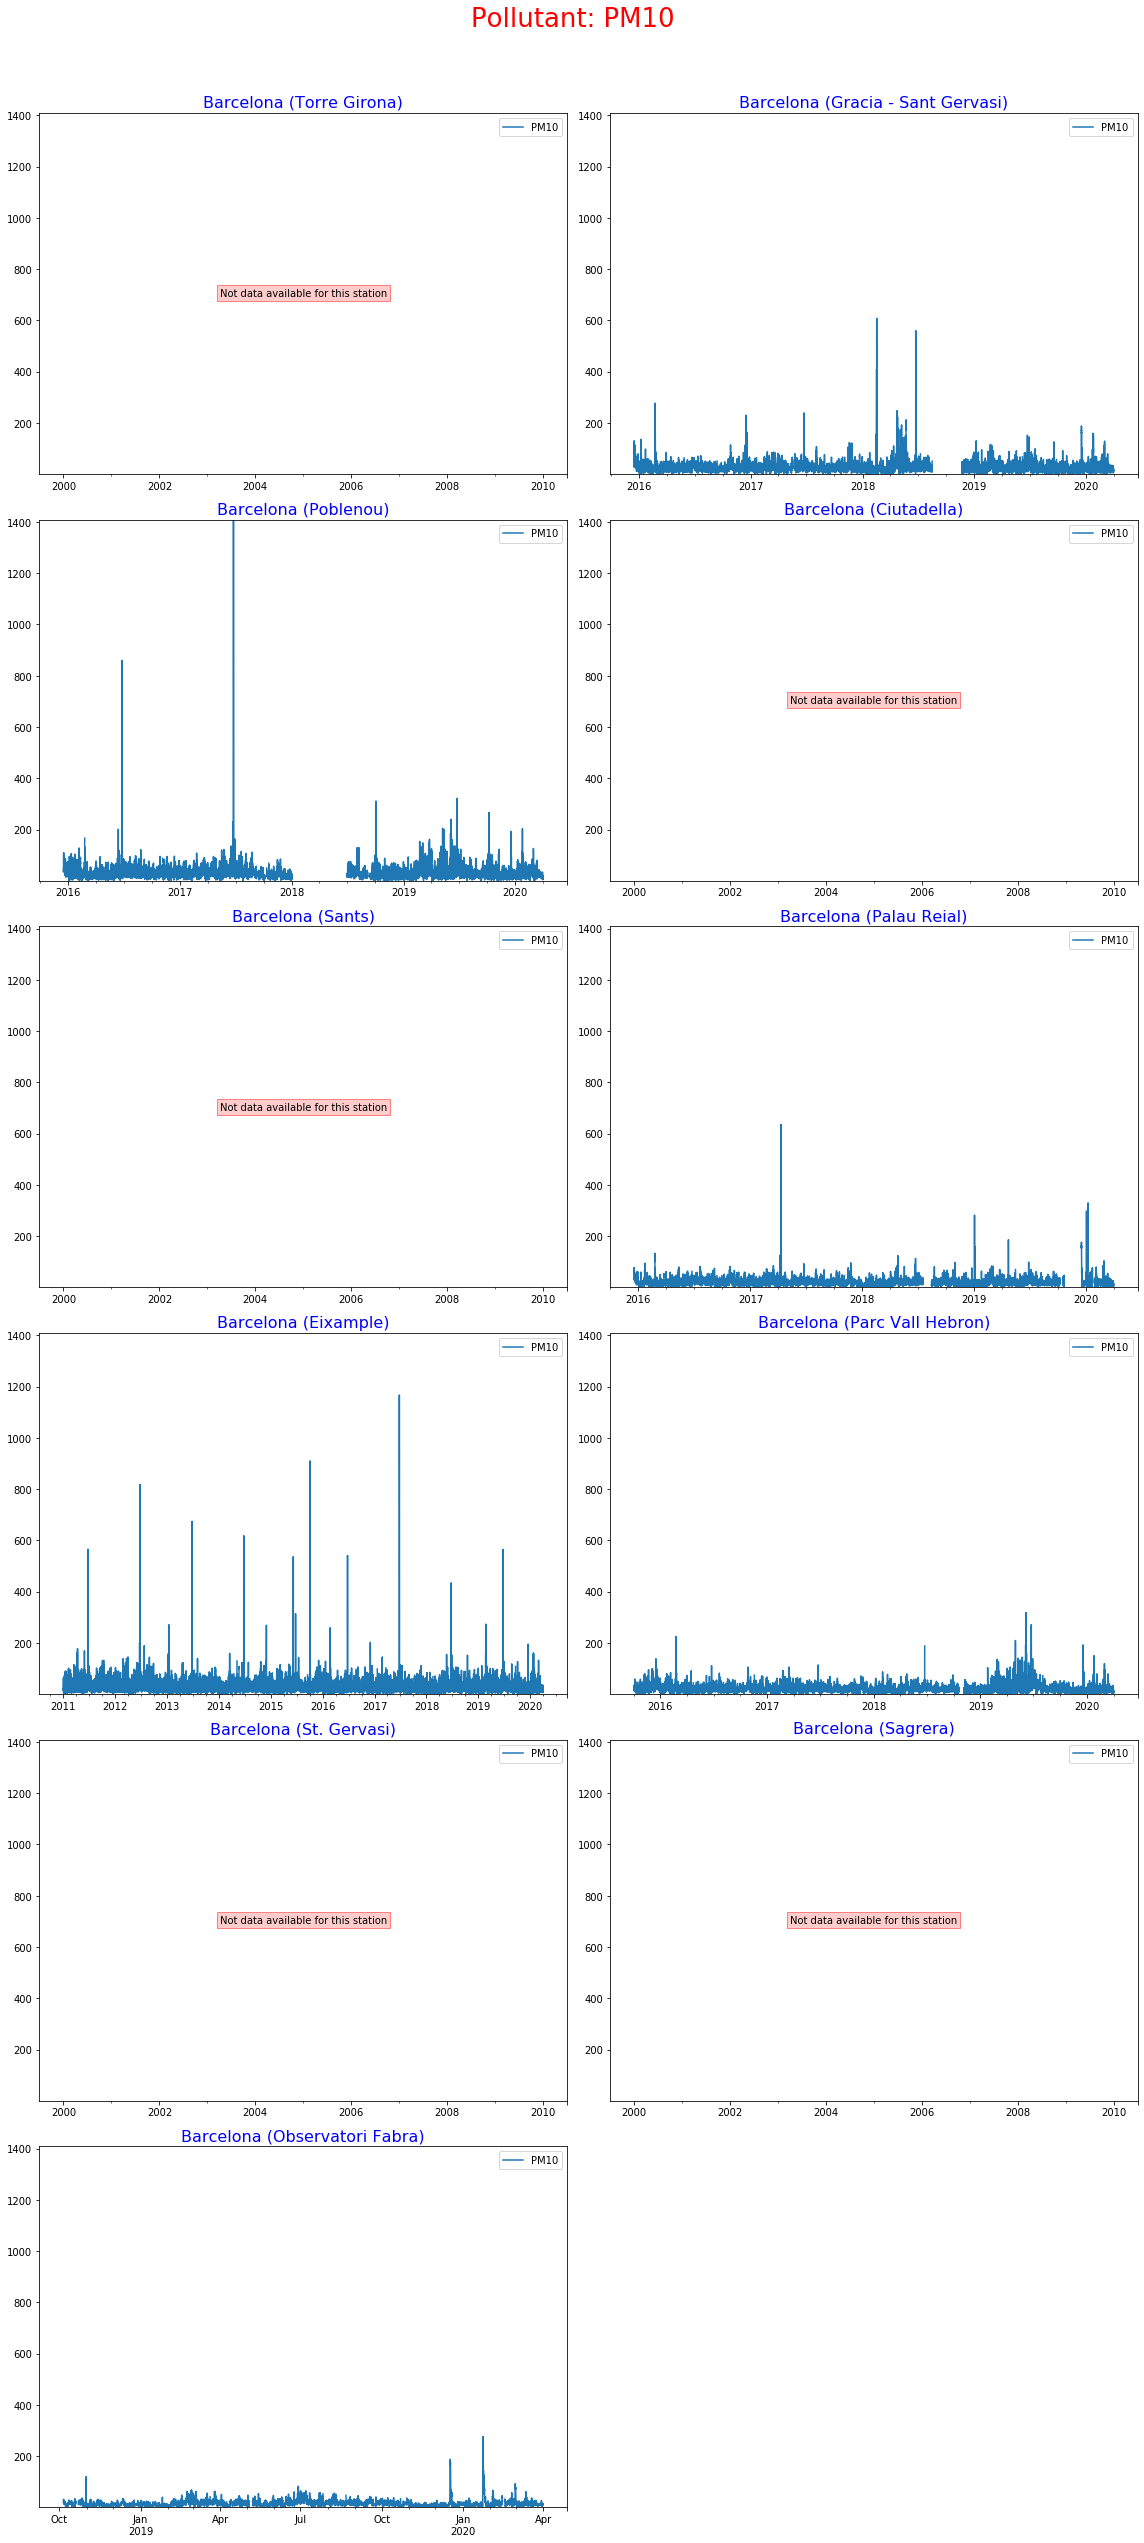

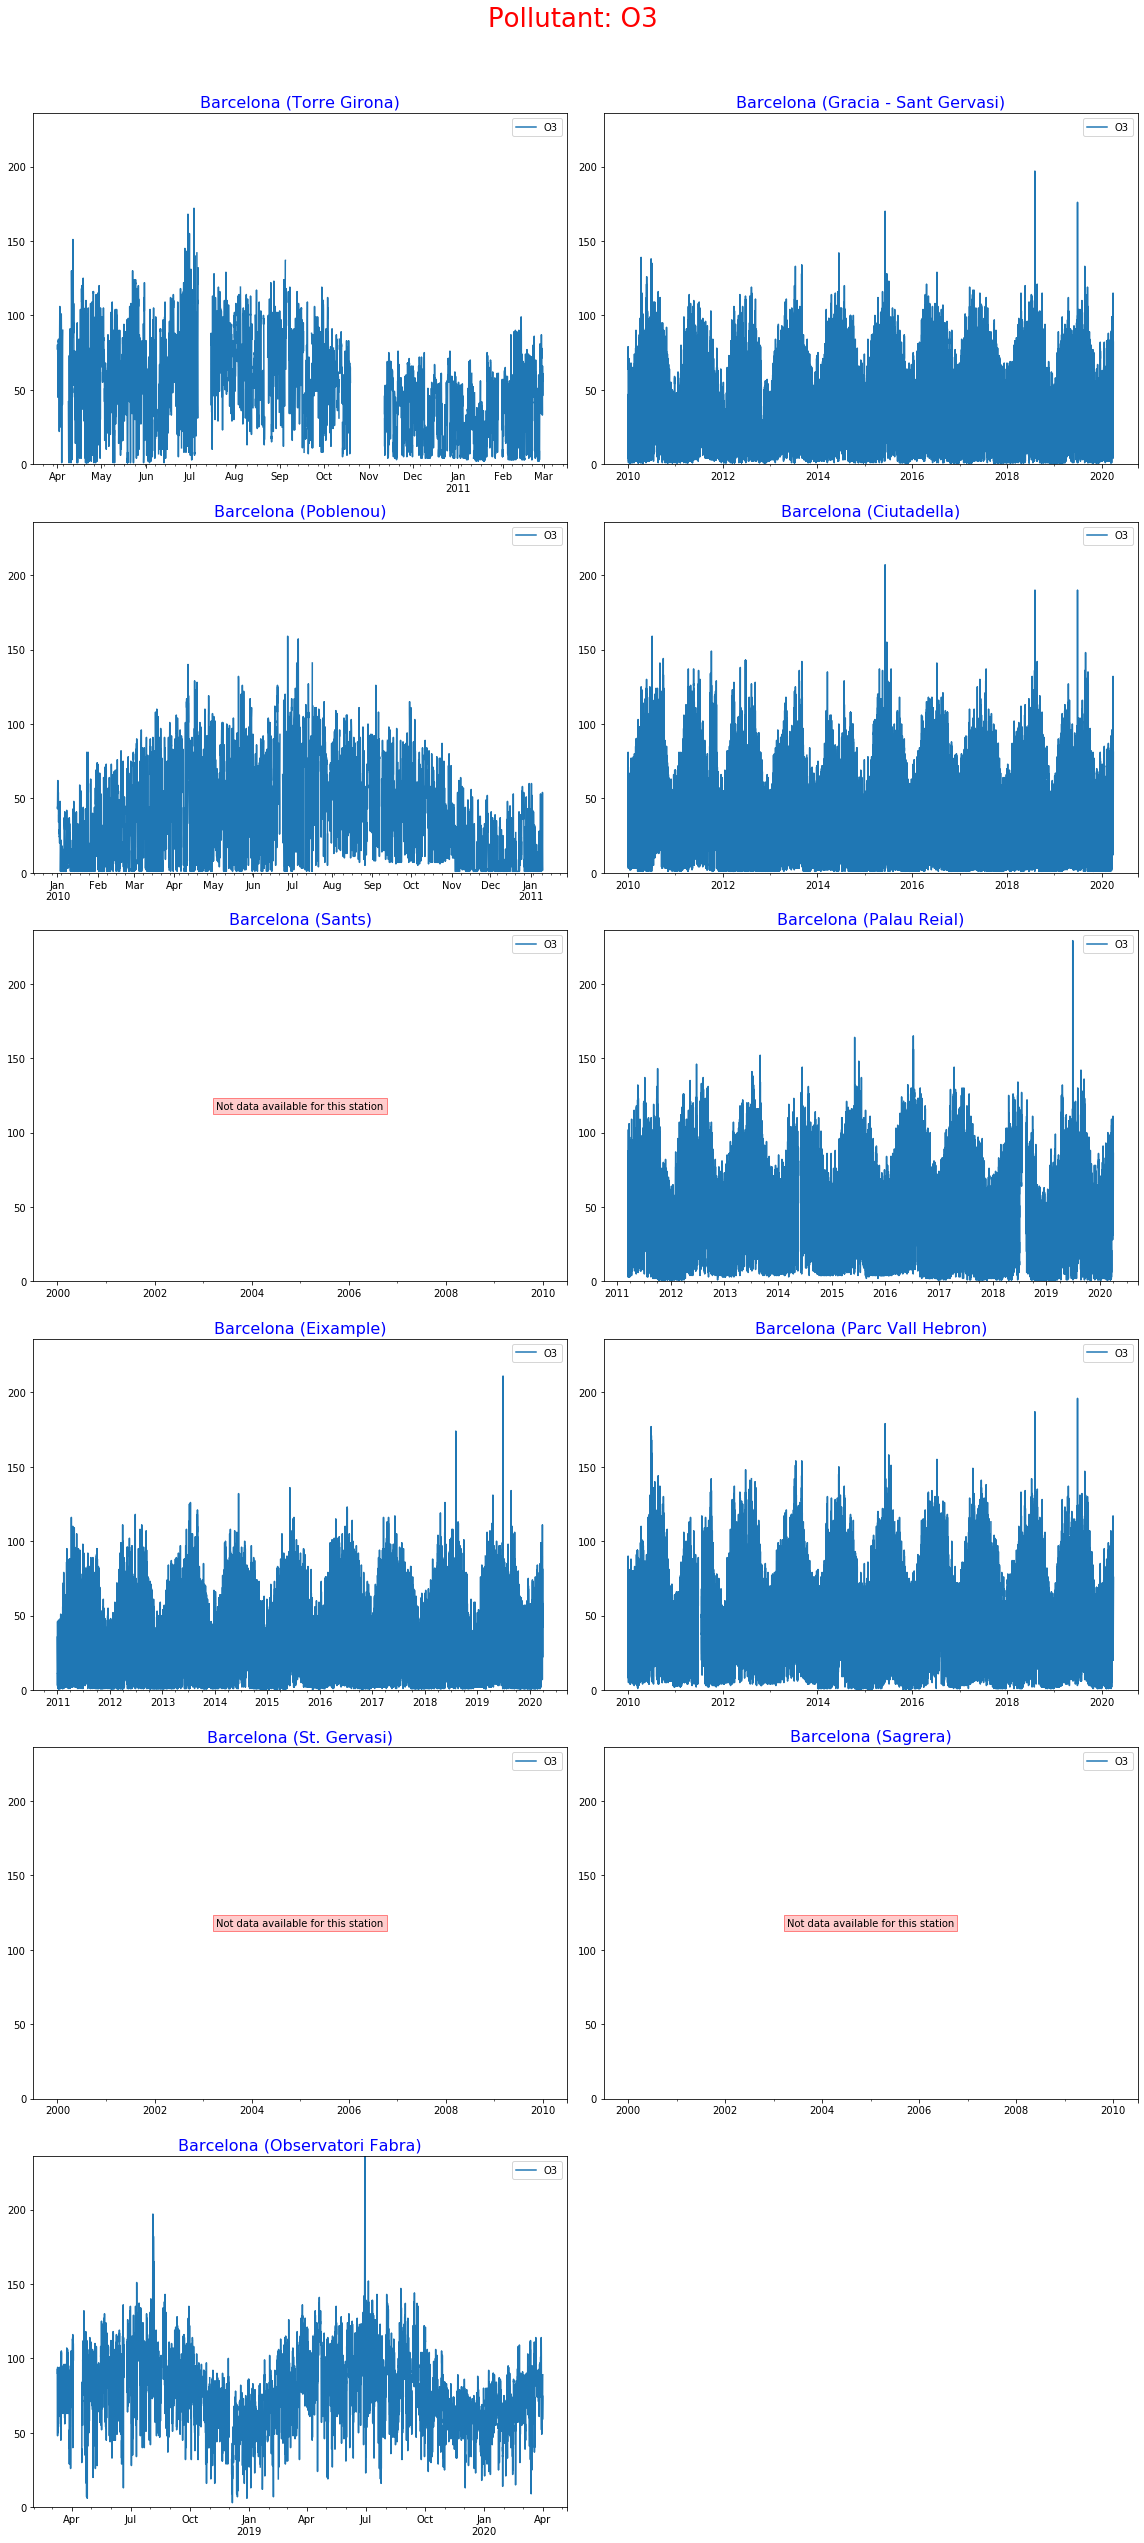

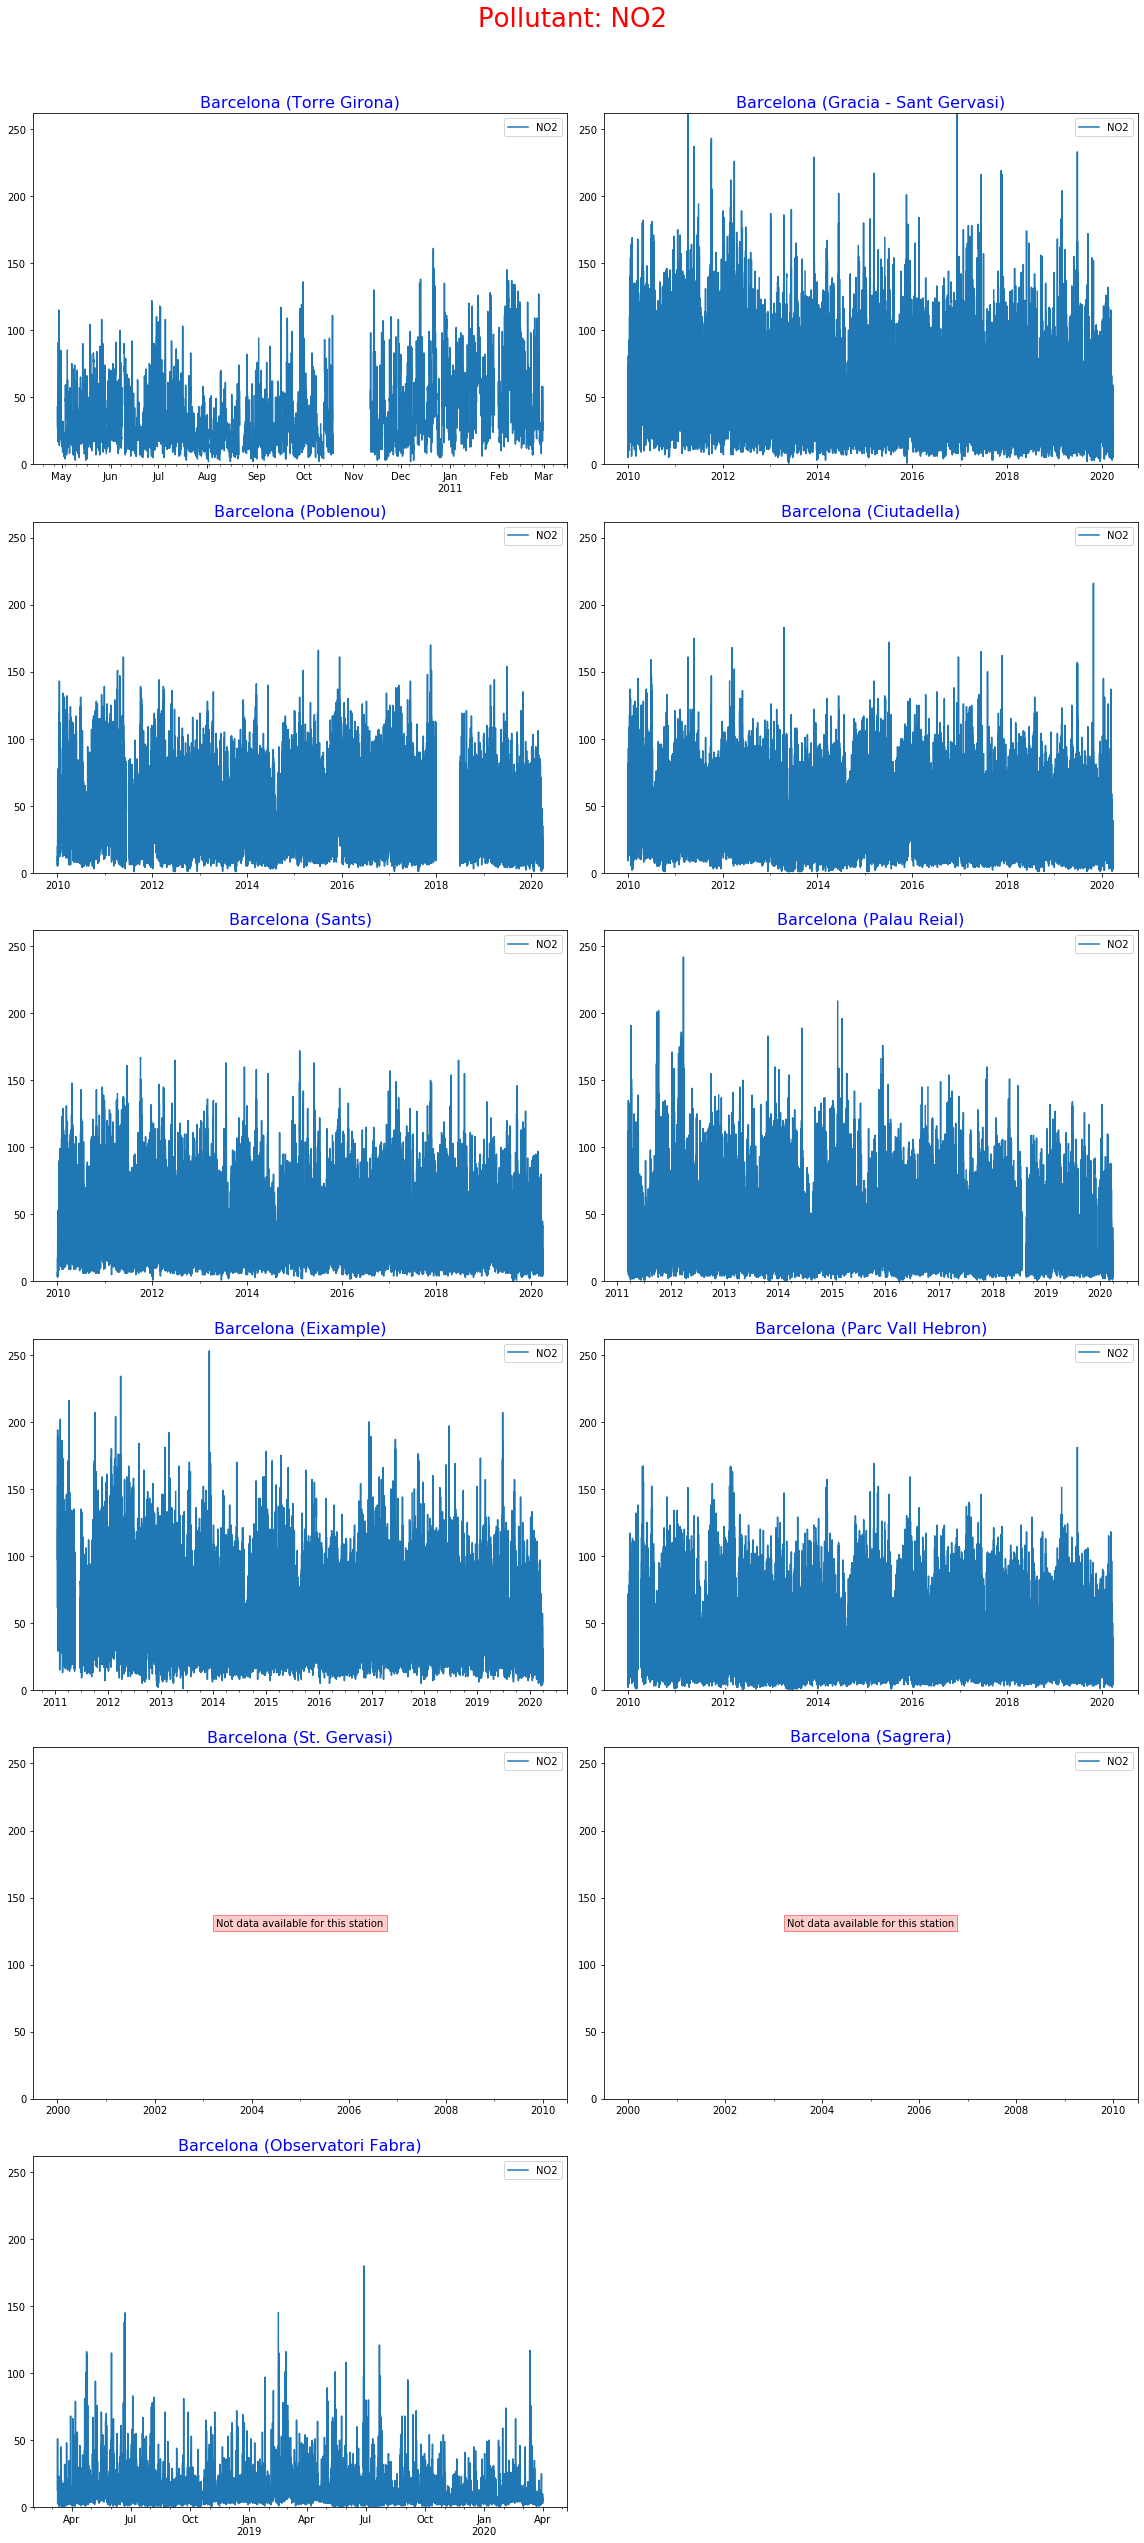

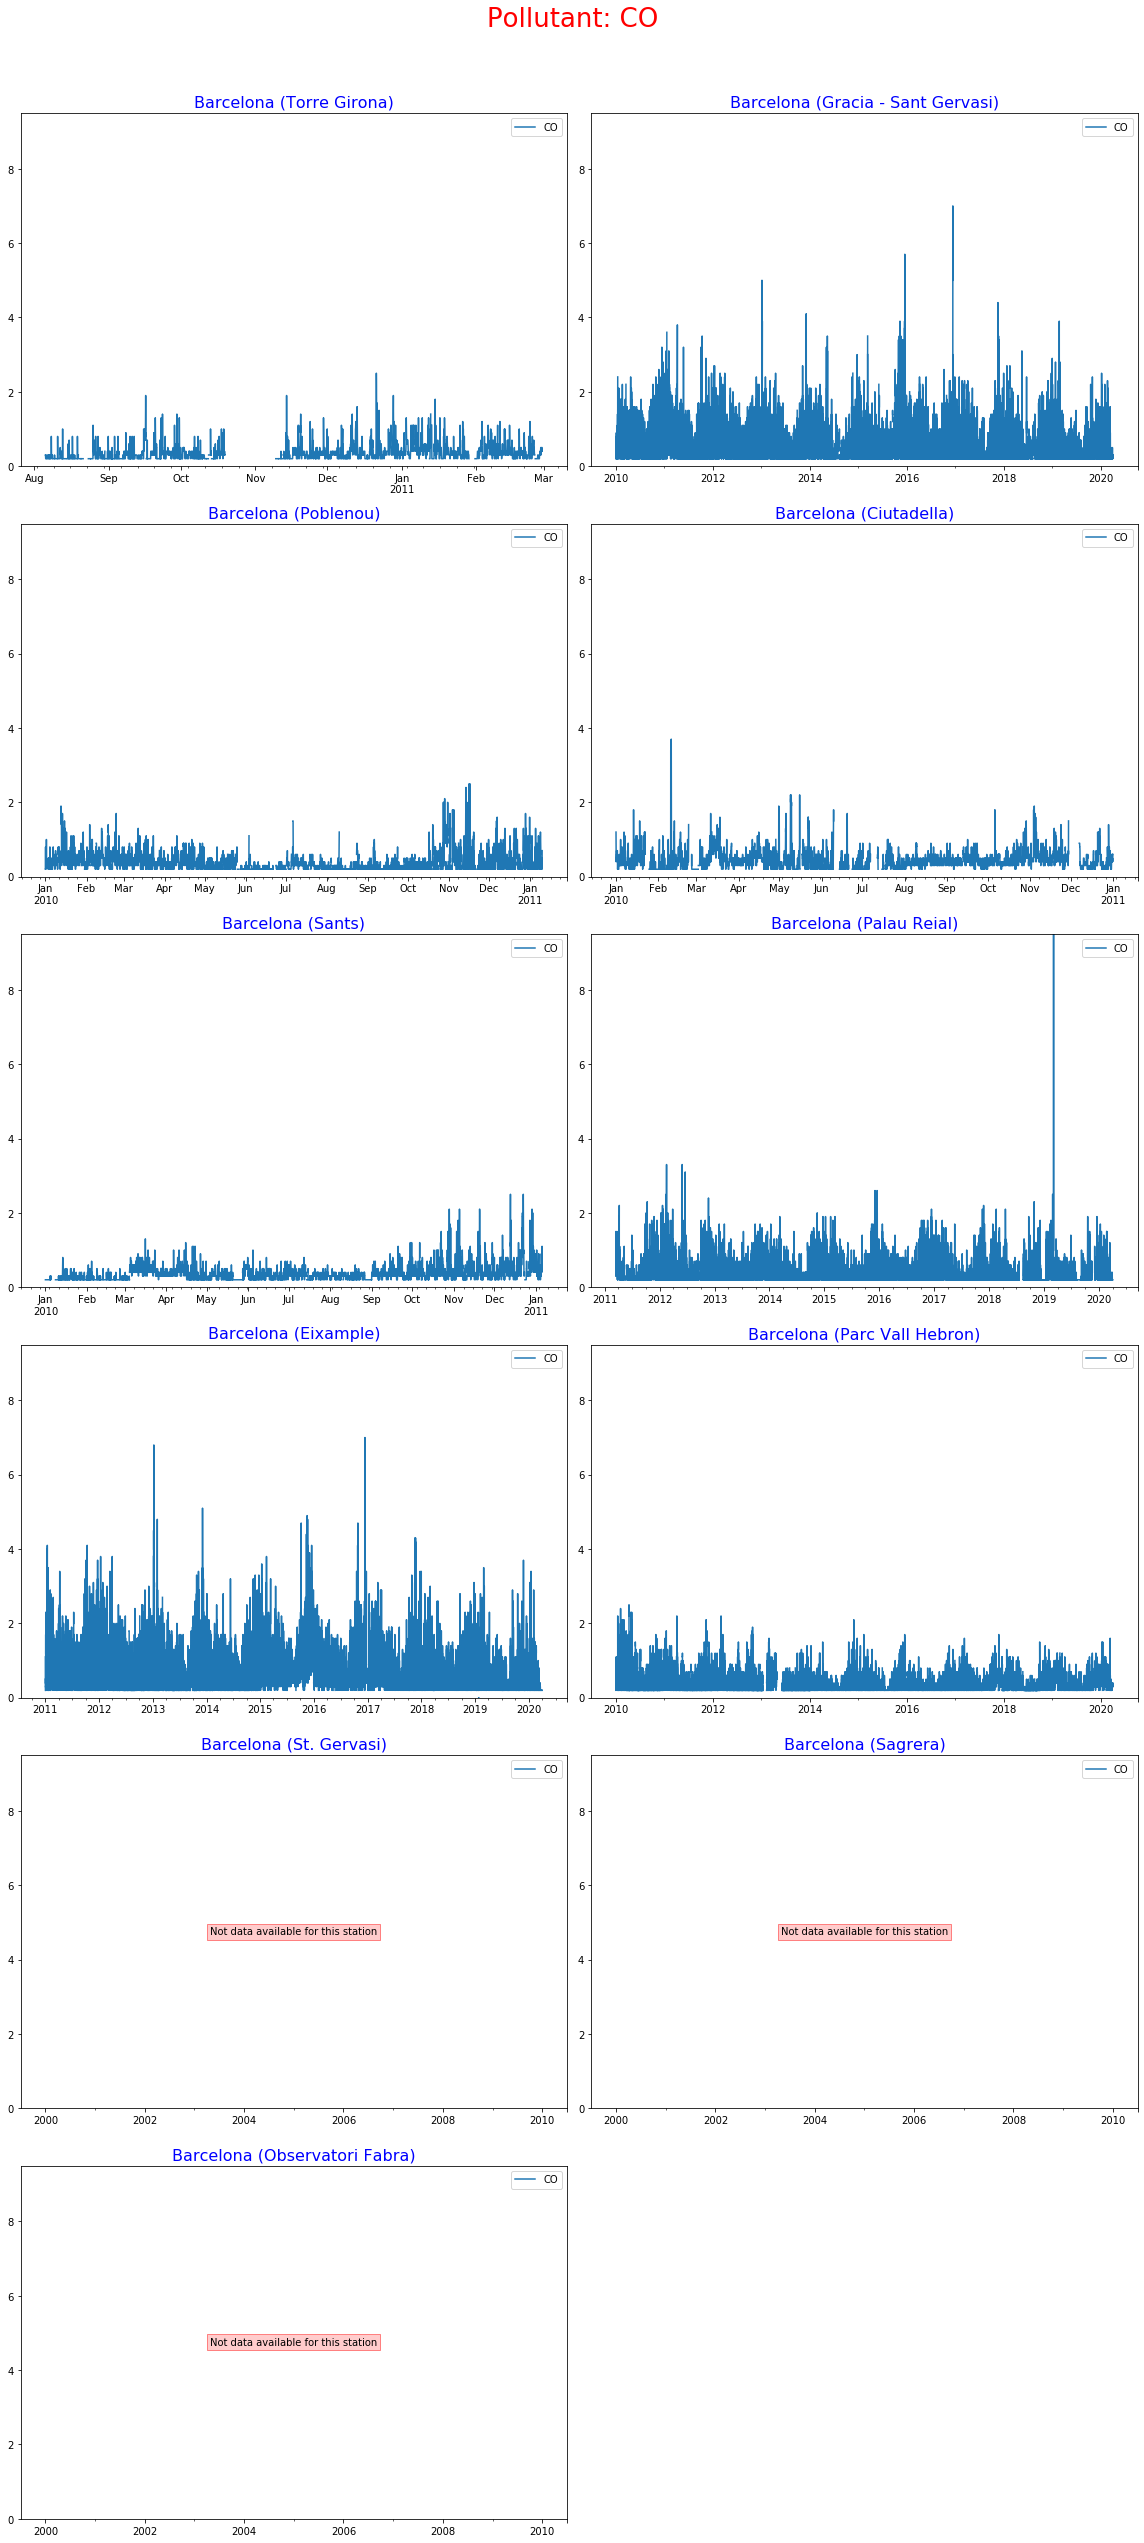

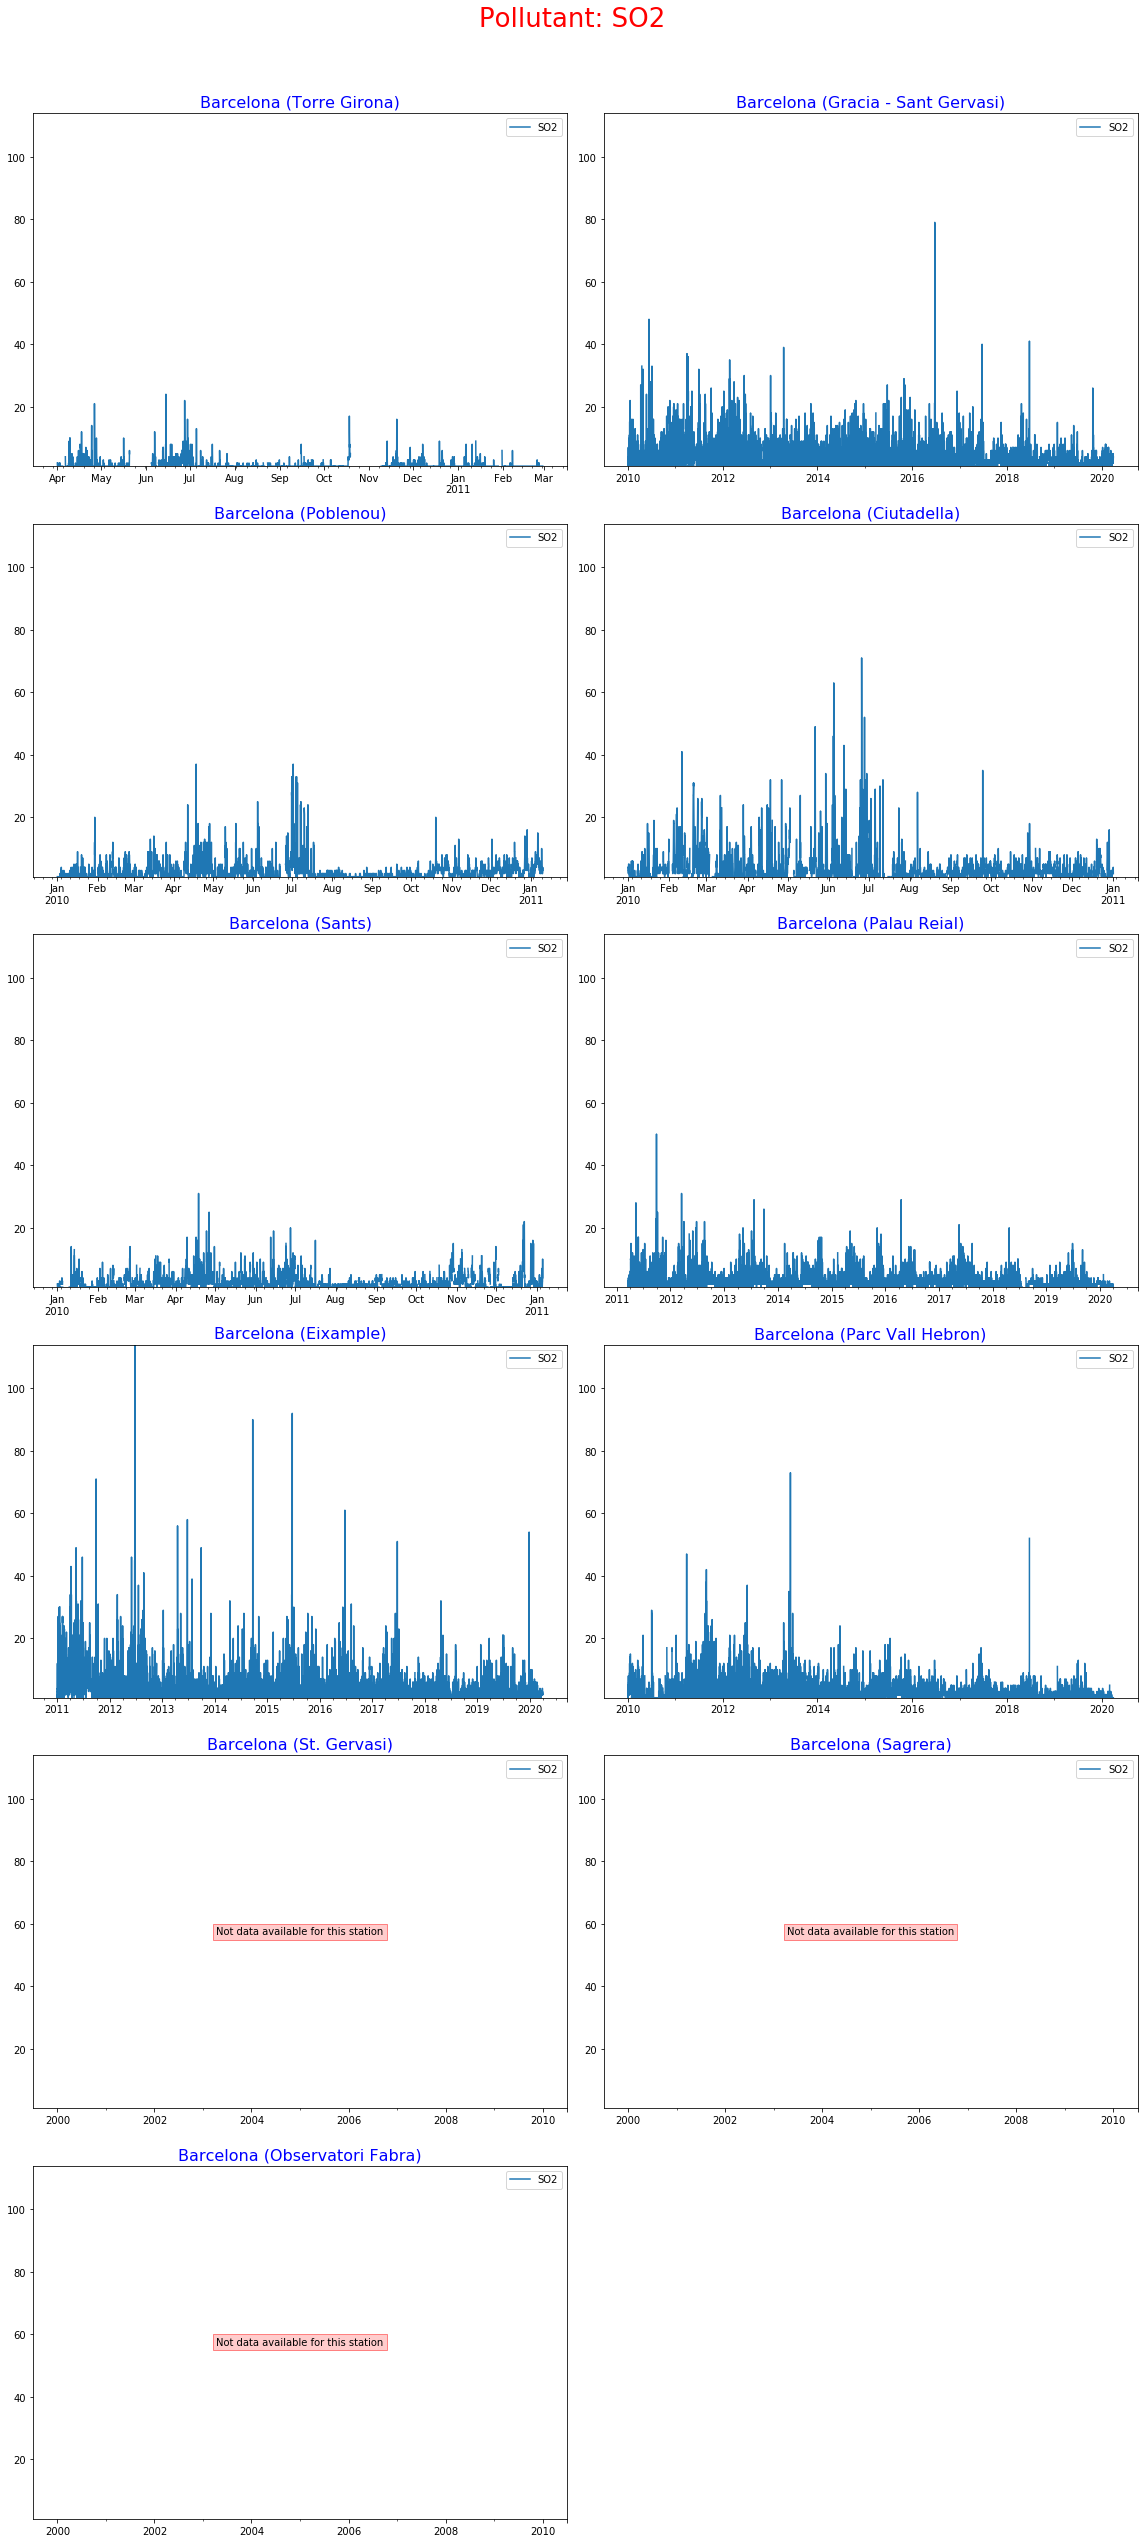

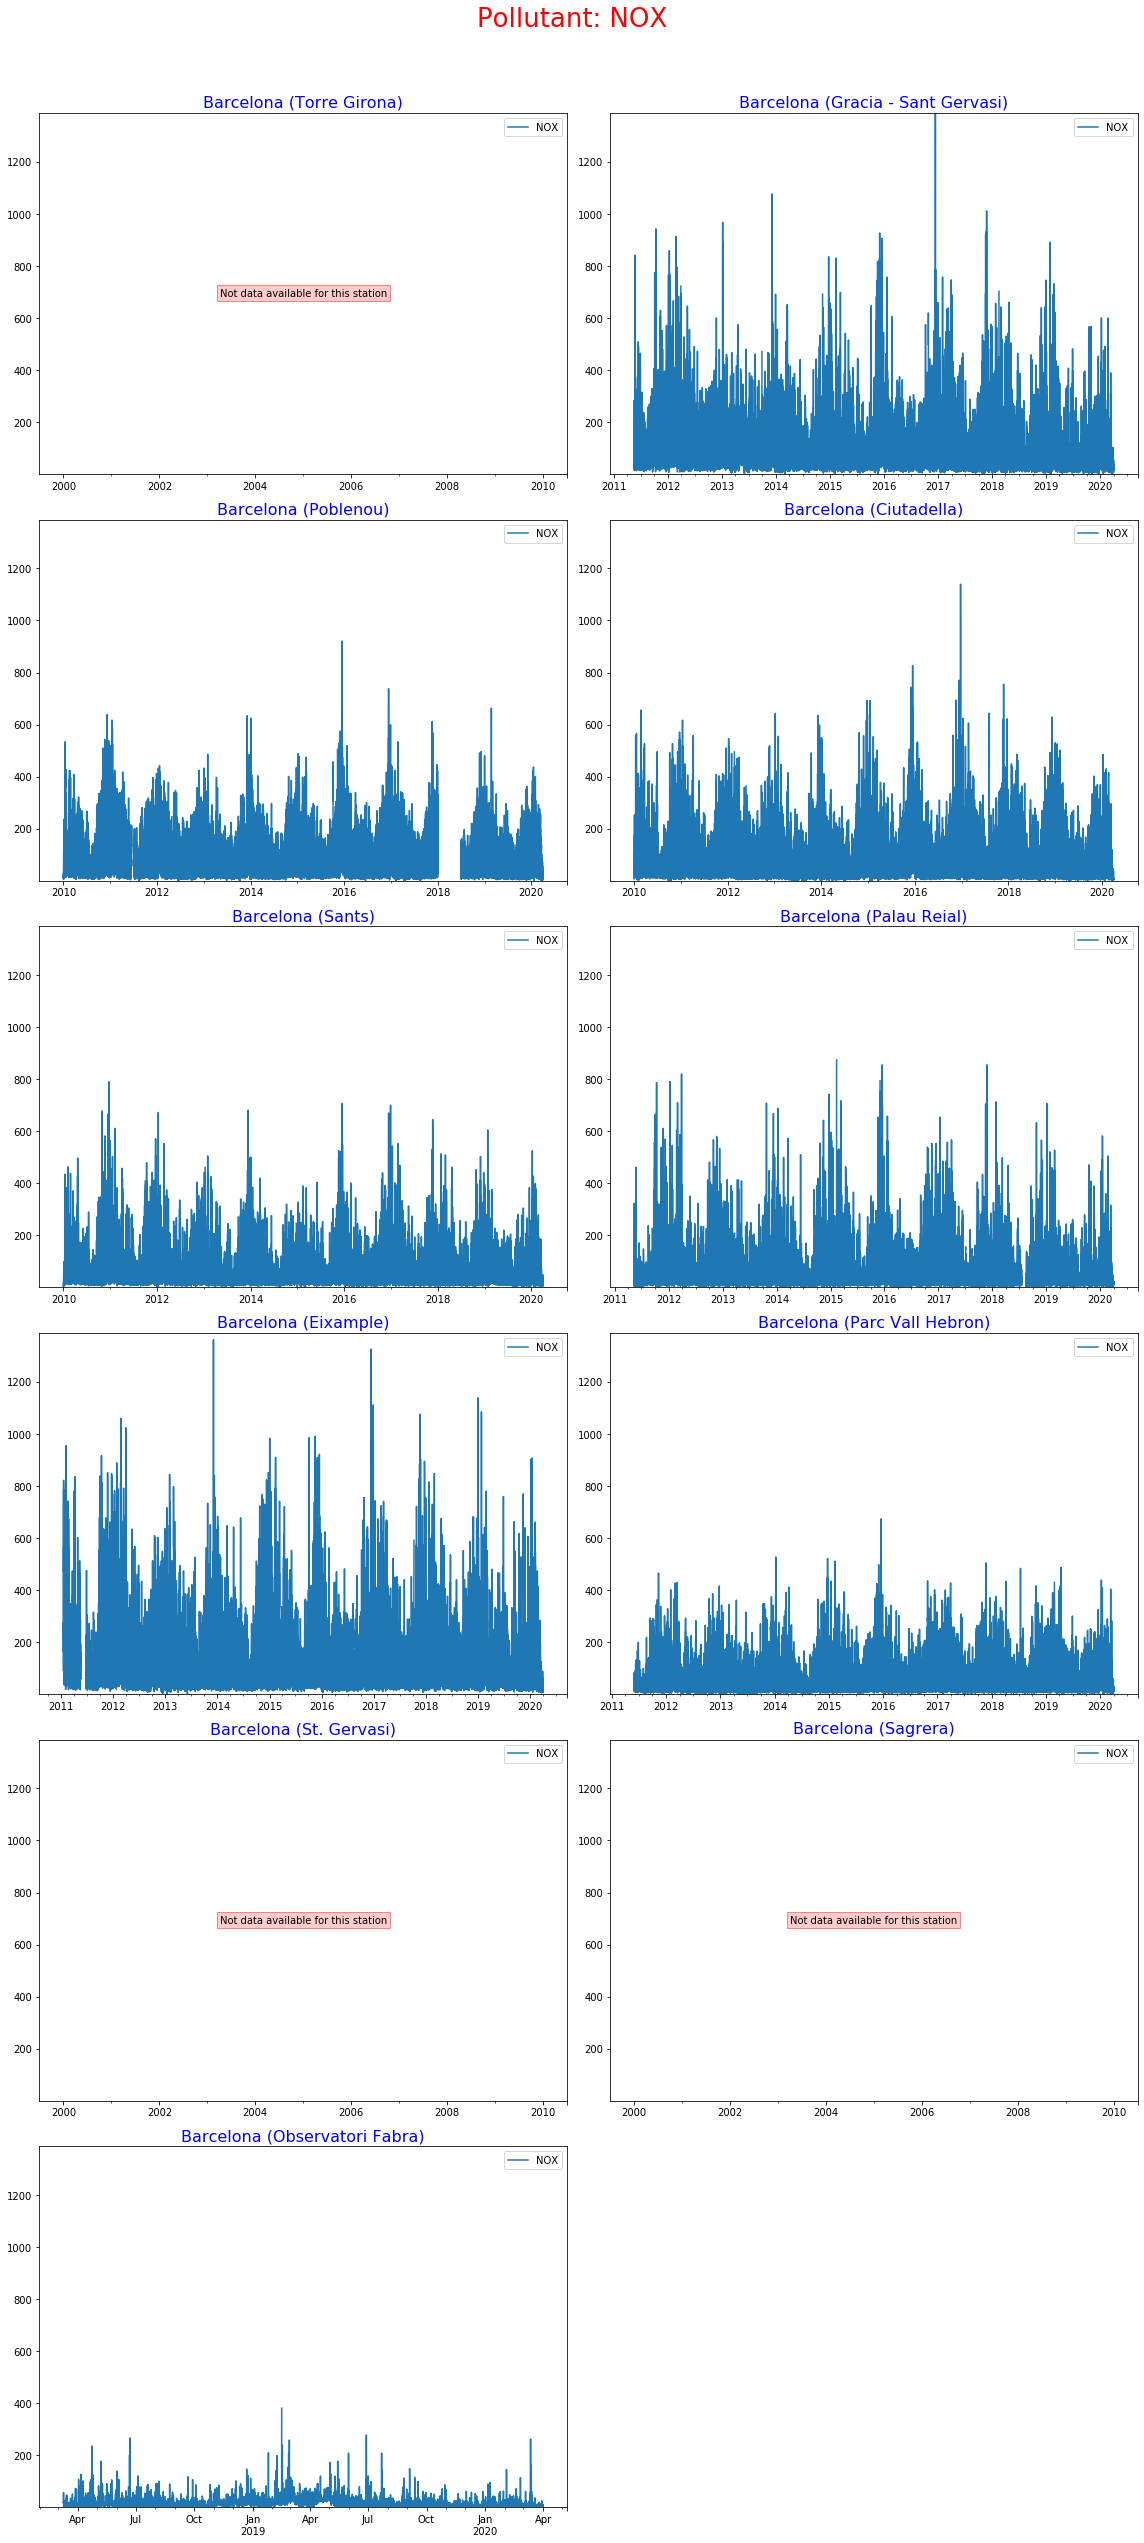

<Figure size 1152x2592 with 0 Axes>

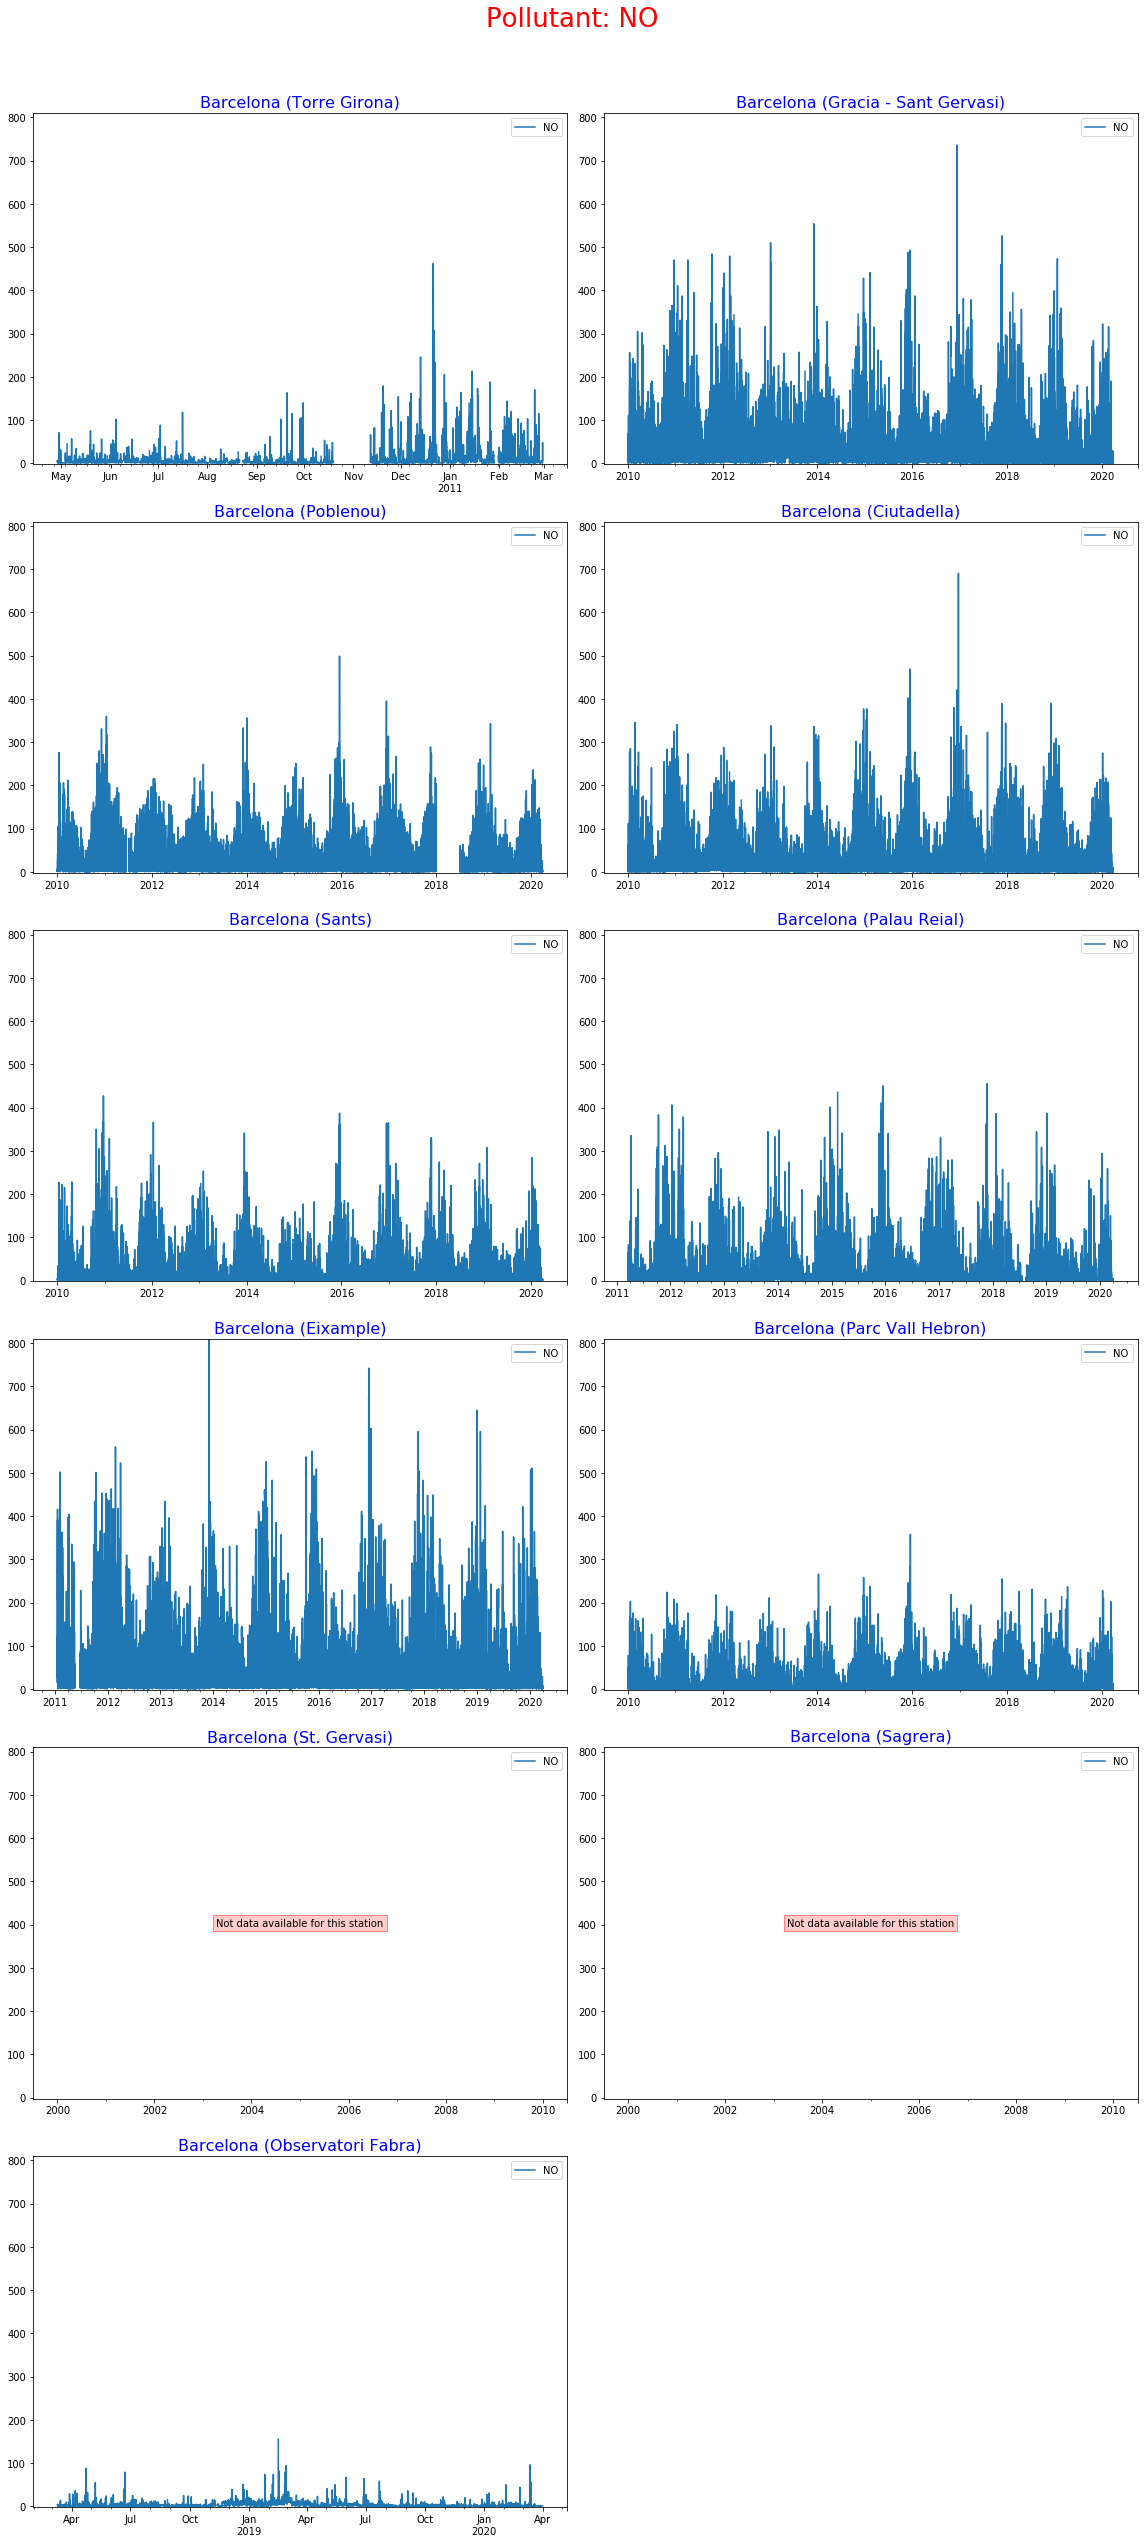

<Figure size 1152x2592 with 0 Axes>

In [27]:
idStations = data_air_hourly['CODI_EOI'].unique()
nroItems=len(idStations)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))

variables=data_air['CONTAMINANT'].unique()
#variables['PM10', 'O3', 'NO2', 'CO', 'SO2', 'NOX', 'NO']
#variables=np.array(['NO', 'NO2','NOX','PM10','CO','O3','SO2'])

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*8,nrows*6))
    for idStation, ax in zip(idStations, axes.flatten()) :
        if idStation:
            nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
            title='{}'.format(nom_estacio)
            try:
                data=data_air_hourly.loc[(data_air_hourly["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')    
                if data.count()[0] > 0:  
                    data.plot(ax=ax)     
                    ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax.set_title(title, fontsize=16, color='blue')
                    ax.set_xlabel('')
                else:
                    data.plot(ax=ax)
                    text='Not data available for this station'
                    ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
                            bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
                    #plt.text(5, 5, text, ha='right', rotation=-15, wrap=True)
                    ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax.set_title(title, fontsize=16, color='blue')
                    ax.set_xlabel('')
            except:
                ax.remove()
        else:
            ax.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 2.2. Selección de estaciones

Para nuestro modelo, utilizaremos solamente aquellas estaciones en las que se recogen el mayor número de variables. Por lo tanto, descartaremos las estaciones de St. Gervasi y Sagrera. Para estas estaciones no tenemos ninguna instacia válida, tal y como se refleja en las gráficas anteriores. Probablemente esto se deba a que sean estaciones antiguas ya desmanteladas. 

En la tabla de abajo mostramos, para cada estación de vigilancia, las fechas de inicial y final para las que tenemos valores de cada contaminante registrado. 

In [28]:
datas = pd.DataFrame()
stations=data_air_hourly['CODI_EOI'].unique()
variables=data_air['CONTAMINANT'].unique()
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_air_hourly.loc[data_air_hourly['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        row[variable+'_first'] = [ts.first_valid_index()]
        row[variable+'_last'] = [ts.last_valid_index()]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

,CODI_EOI,NOM_ESTACIO,TIPUS_ESTACIO,AREA URBANA,PM10_first,PM10_last,O3_first,O3_last,NO2_first,NO2_last,CO_first,CO_last,SO2_first,SO2_last,NOX_first,NOX_last,H2S_first,H2S_last,NO_first,NO_last,PS_first,PS_last
0,8019056,Barcelona (Torre Girona),background,urban,None,None,2010-04-01 00:00:00,2011-02-28 10:00:00,2010-04-28 10:00:00,2011-02-28 10:00:00,2010-08-05 14:00:00,2011-02-28 10:00:00,2010-04-01 00:00:00,2011-02-28 10:00:00,None,None,None,None,2010-04-28 10:00:00,2011-02-28 10:00:00,None,None
1,8019044,Barcelona (Gracia - Sant Gervasi),traffic,urban,2015-12-16 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 01:00:00,2020-03-31 23:00:00,2011-05-16 16:00:00,2020-03-31 23:00:00,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None
2,8019004,Barcelona (Poblenou),background,urban,2015-12-16 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2011-01-10 08:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2011-01-10 08:00:00,2010-01-01 00:00:00,2011-01-10 08:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None
3,8019050,Barcelona (Ciutadella),background,urban,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2010-12-31 23:00:00,2010-01-01 00:00:00,2010-12-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None
4,8019042,Barcelona (Sants),traffic,urban,None,None,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2011-01-05 11:00:00,2010-01-01 00:00:00,2011-01-05 11:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None
5,8019057,Barcelona (Palau Reial),background,urban,2015-12-17 18:00:00,2020-03-31 23:00:00,2011-03-17 13:00:00,2020-03-31 23:00:00,2011-03-17 16:00:00,2020-03-31 23:00:00,2011-03-17 16:00:00,2020-03-31 23:00:00,2011-03-17 15:00:00,2020-03-31 23:00:00,2011-05-11 16:00:00,2020-03-31 23:00:00,None,None,2011-03-17 16:00:00,2020-03-31 23:00:00,None,None
6,8019043,Barcelona (Eixample),traffic,urban,2011-01-01 00:00:00,2020-03-31 23:00:00,2011-01-01 00:00:00,2020-03-31 23:00:00,2011-01-17 17:00:00,2020-03-31 23:00:00,2011-01-01 00:00:00,2020-03-31 23:00:00,2011-01-01 02:00:00,2020-03-31 23:00:00,2011-01-17 17:00:00,2020-03-31 23:00:00,None,None,2011-01-17 17:00:00,2020-03-31 23:00:00,None,None
7,8019054,Barcelona (Parc Vall Hebron),background,urban,2015-10-02 15:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2010-01-01 00:00:00,2020-03-31 23:00:00,2011-05-30 12:00:00,2020-03-31 23:00:00,None,None,2010-01-01 00:00:00,2020-03-31 23:00:00,None,None
8,8019003,Barcelona (St. Gervasi),traffic,urban,None,None,None,None,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,None,NaT,NaT,None,None
9,8019039,Barcelona (Sagrera),traffic,urban,None,None,None,None,NaT,NaT,NaT,NaT,NaT,NaT,None,None,None,None,NaT,NaT,None,None


Si analizamos la tabla de arriba, vemos que para la estación de Torre Girona únicamente tenemos datos hasta fin de febrero del año 2011. Por lo tanto, esta estación tampoco nos servirá para nuestros objetivos. Puesto que También descartamos las estaciones de Sants y Ciutadella, por no tener registros de PM<sub>10</sub>.

Con el objetivo de analizar distintas tipologias de estaciones, vamos a seleccionar al menos una estación de cada tipo. Así, si queremos poder analizar los resultados de nuestro modelo con una estación suburbana, necesariamente tendremos que elegir la estación de Observatori Fabra, a pesar de que, en este caso, solamente se han registrado datos desde marzo de 2018, y para PM<sub>10</sub> desde octubre de 2018. seleccionamos la única estación que hay en area suburbana, Observatori Fabra, y, de aquellas en area urbana, una de tipo 'traffic', Eixample, y otra de tipo 'background', Poblenou. Además, con vista a comparar la influencia de la cercanía al mar, incluiremos en este análisis la estación de Parc Vall Hebron. Así, si solamente visualizamos estas estaciones en el mapa, tenemos:

In [29]:
# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, 
               #min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

studied_stations = ['Barcelona (St. Gervasi)', 'Barcelona (Sagrera)', 'Barcelona (Torre Girona)']
codiEOIs = ['8019003', '8019039', '8019056']
for index, row in data_air_stations.iterrows():
    #if row['NOM_ESTACIO'] in studied_stations: 
    if row['CODI_EOI'] in codiEOIs: 
        continue
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)
m

Ahora vamos a añadir a este mapa las estaciones de meteorológicas, en Barcelona, que ya hemos visto en otro análisis anterior.

In [30]:
# Read meteo stations metadata file
meteoStationsPath='../data/meteo/meta/meteo_stations.json'
if not os.path.exists(meteoStationsPath):
    meteoStationsPath='https://analisi.transparenciacatalunya.cat/resource/yqwd-vj5e.json'
meteoStations=pd.read_json(meteoStationsPath, orient='records', encoding='UTF-8')

Filtramos para quedarnos exclusivamente con las estaciones meteorológicas ubicadas en Barcelona que se encuentren operativa.

In [31]:
# Aggregate by most frequent value
data_meteo_stations=meteoStations.loc[(meteoStations['nom_estat_ema'] == 'Operativa') & (meteoStations['nom_municipi'] == 'Barcelona'), 
                  ['longitud','latitud','emplacament','data_inici','codi_estacio']]
data_meteo_stations

,longitud,latitud,emplacament,data_inici,codi_estacio
2,2.16775,41.38390,Facultat de Geografia i Història. c. Montalegr...,2006-10-11T00:00:00.000,X4
74,2.10540,41.37919,Pistes UB,2008-04-17T00:00:00.000,X8
164,2.18847,41.38943,Zoo,2006-09-22T00:00:00.000,X2
221,2.12388,41.41843,Observatori Fabra,1995-11-03T00:00:00.000,D5


Y añadimos estas estaciones meteorológicas al mapa anterior, en color gris, para distingirlas de las estaciones de vigilancia de contaminación del aire.

In [32]:
for index, row in data_meteo_stations.iterrows():
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='lightgray', icon='cloud'),
    ).add_to(m)
m

Según vemos sobre el mapa, observamos que existe una estación meteorológica en el Observatori Fabra. Por lo que, resulta lógico utilizar los datos recogidos por esta estación para analizarlos conjuntamente con los datos de contaminación recogidos en la estación de vigilancia del aire, situada en la misma posición. Para las demás estaciones de vigilancia utilizaremos los datos recogidos en las estaciones meteorológicas más próximas. De momento, no descartaremos los datos de ninguna estación meteorológica.

A continuación, vamos a añadir los tramos de la ciudad de Barcelona para los que se registra información de tránsito de vehículos.

In [33]:
# Header definition
columns=['Tramo', 'Descripcion', 'Coordenadas']
dtype={'Tramo':np.integer, 'Descripcion':object, 'Coordenadas':object}

filename = "../data/trafico/meta/transit_relacio_trams.csv"
data_tramos = pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "UTF-8", dtype=dtype)
data_tramos.head()

,Tramo,Descripcion,Coordenadas
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),"2.11203535639414,41.3841912394771,2.1015028628..."
1,2,Diagonal (Doctor Marañón a Ronda de Dalt),"2.111944376806616,41.38446666680338,2.10159408..."
2,3,Diagonal (Doctor Marañón a Pl. Pius XII),"2.112093343037027,41.38422850920645,2.12264979..."
3,4,Diagonal (Pl. Pius XII a Doctor Marañón),"2.122592049318304,41.38719094189204,2.11196902..."
4,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),"2.122657659295115,41.38694195794678,2.12755961..."


Añadimos estos datos al mapa de Barcelona:

In [34]:
# In order to generate random colors
r = lambda: random.randint(0,255)

# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='<b>{}</b><br>{}'.format(row['Tramo'], row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

En este caso, para seleccionar los tramos de la vía que vamos a utilizar en nuestro trabajo, observamos aquellos tramos que se encuentren más cercanos a cada una de las estaciones de vigilancia de contaminación del aire. Al final obtendremos un dato, por cada estación, a partir del valor mayor de todos los registrados en los tramos cercanos a esa estación en un momento dado. Así, realizamos la siguiente selección de tramos por estación:

- Observatori Fabra (8019058): 64, 65, 511 y 512
- Parc Vall Hebron (8019054): 438 y 439
- Poblenou (8019004): 421 y 481
- Ciutadella (8019050): 289, 290, 489 y 490
- Eixample (8019043): 118, 138 y 142
- Gracia - Sant Gervasi (8019044): 77, 78, 79, 80 y 467
- Sants (8019042): 50, 51, 129, 448 y 449
- Palau Reial (8019057): 3, 4, 16 y 17


In [35]:
# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, 
               #min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

codiEOIs = ['8019003', '8019039', '8019056']
for index, row in data_air_stations.iterrows():
    if row['CODI_EOI'] in codiEOIs: continue
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)

for index, row in data_meteo_stations.iterrows():
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='lightgray', icon='cloud'),
    ).add_to(m)
    r = lambda: random.randint(0,255)

studied_trams = [3, 4, 16, 17, 50, 51, 129, 448, 449, 
                 77, 78, 79, 80, 467, 118, 138, 142,
                 289, 290, 489, 490, 421, 481,
                 438, 439, 64, 65, 511, 512]
# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    if not row['Tramo'] in studied_trams: continue
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='<b>{}</b><br>{}'.format(row['Tramo'], row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

Para finalizar este apartado vamos a obtener una versión del dataframe de datos de contaminantes, data_air_hourly, al cual eliminamos aquellos datos que no nos servirán en nuestro estudio posterior.

In [36]:
codiEOIs = ['8019003', '8019039', '8019056']
data_air_hourly_red = data_air_hourly[data_air_hourly['CODI_EOI'].map(lambda x: x not in codiEOIs)]
data_air_hourly_red = data_air_hourly_red.drop(['H2S', 'PS'], axis=1)
data_air_hourly_red.head()

,DATA,CO,NO,NO2,NOX,O3,PM10,SO2,CODI_EOI
70128,2010-01-01,0.2,3.0,13.0,NaN,64.0,NaN,NaN,8019044
159960,2010-01-01,0.2,3.0,12.0,17.0,44.0,NaN,1.0,8019004
609120,2010-01-01,1.2,3.0,27.0,30.0,55.0,NaN,4.0,8019050
339624,2010-01-01,0.2,2.0,17.0,19.0,NaN,NaN,2.0,8019042
519288,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8019057


Guardamos el nuevo dataframe en un fichero:

In [37]:
data_air_hourly_red.to_csv(r'data_air_hourly_red.csv', index = False)

# Bibliografía

- Numpy developer manual. https://numpy.org/devdocs/

- Pandas documentation. https://pandas.pydata.org/docs/

- Folium. https://python-visualization.github.io/folium/